In [96]:
from google.colab import files
import pandas as pd
import os
import time
import json
import logging
import matplotlib.pyplot as plt
import seaborn as sns


# Subir archivo manualmente
uploaded = files.upload()

# Crear carpeta RAW si no existe
BASE_DIR = "/content/data_integration"
RAW_DIR = os.path.join(BASE_DIR, "raw")
os.makedirs(RAW_DIR, exist_ok=True)

# Mover archivo subido a RAW
file_name = list(uploaded.keys())[0]
target = os.path.join(RAW_DIR, file_name)

# Mover archivo a la carpeta raw
!cp "{file_name}" "{target}"
print("✅ CSV hospital copiado a:", target)

# Leer e imprimir preview
df = pd.read_csv(target)
print("📌 Vista previa del dataset cargado:")
print(df.head())        # primeras 5 filas
print("\n🔍 Información general del dataset:")
print(df.info())



Saving hospital_santiago_280 (1).csv to hospital_santiago_280 (1) (4).csv
✅ CSV hospital copiado a: /content/data_integration/raw/hospital_santiago_280 (1) (4).csv
📌 Vista previa del dataset cargado:
   paciente_id  nombre  apellido  edad sexo       comuna  servicio_clinico  \
0            1   María  González    45    F     Santiago  Medicina Interna   
1            2    Juan     Pérez    67    M  Providencia       Cardiología   
2            3  Carmen     López    34    F   Las Condes       Ginecología   
3            4   Pedro  Martínez    78    M        Ñuñoa        Neurología   
4            5     Ana   Jiménez    29    F     La Reina     Traumatología   

  fecha_ingreso      diagnostico_principal  dias_hospitalizacion  costo_total  \
0    2024-01-15      Hipertensión arterial                     3       450000   
1    2024-01-18    Infarto agudo miocardio                     7      1200000   
2    2024-01-20               Parto normal                     2       350000   
3    20

In [73]:
df.head()

,paciente_id,nombre,apellido,edad,sexo,comuna,servicio_clinico,fecha_ingreso,diagnostico_principal,dias_hospitalizacion,costo_total,medico_tratante,estado_alta
0,1,María,González,45,F,Santiago,Medicina Interna,2024-01-15,Hipertensión arterial,3,450000,Dr. Rodríguez,Alta médica
1,2,Juan,Pérez,67,M,Providencia,Cardiología,2024-01-18,Infarto agudo miocardio,7,1200000,Dr. Silva,Alta médica
2,3,Carmen,López,34,F,Las Condes,Ginecología,2024-01-20,Parto normal,2,350000,Dra. Morales,Alta médica
3,4,Pedro,Martínez,78,M,Ñuñoa,Neurología,2024-01-22,Accidente cerebrovascular,12,2100000,Dr. Torres,Alta médica
4,5,Ana,Jiménez,29,F,La Reina,Traumatología,2024-01-25,Fractura de tibia,5,800000,Dr. Vargas,Alta médica


# **Bloque 2 Limpieza / transformaciones**

In [97]:
df_curated = df.drop_duplicates()       # eliminar duplicados


In [98]:
df_curated = df_curated.fillna("DESCONOCIDO")  # completar valores nulos

Crear carpeta "curated"

In [99]:
CURATED_DIR = os.path.join(BASE_DIR, "curated")
os.makedirs(CURATED_DIR, exist_ok=True)

Guardar archivo limpio

In [100]:
curated_file = os.path.join(CURATED_DIR, "hospital_santiago_curated.csv")
df_curated.to_csv(curated_file, index=False)

print("✅ Proceso batch completo. Datos procesados en:", curated_file)
print("\n📌 Vista previa datos curados:")
print(df_curated.head())

✅ Proceso batch completo. Datos procesados en: /content/data_integration/curated/hospital_santiago_curated.csv

📌 Vista previa datos curados:
   paciente_id  nombre  apellido  edad sexo       comuna  servicio_clinico  \
0            1   María  González    45    F     Santiago  Medicina Interna   
1            2    Juan     Pérez    67    M  Providencia       Cardiología   
2            3  Carmen     López    34    F   Las Condes       Ginecología   
3            4   Pedro  Martínez    78    M        Ñuñoa        Neurología   
4            5     Ana   Jiménez    29    F     La Reina     Traumatología   

  fecha_ingreso      diagnostico_principal  dias_hospitalizacion  costo_total  \
0    2024-01-15      Hipertensión arterial                     3       450000   
1    2024-01-18    Infarto agudo miocardio                     7      1200000   
2    2024-01-20               Parto normal                     2       350000   
3    2024-01-22  Accidente cerebrovascular                    12 

#**Bloque 3 Simulación de ingesta streaming**

Simular streaming leyendo el dataset limpio en "ventanas"

In [101]:
stream_chunk_size = 5  # filas por ventana
num_rows = len(df_curated)

print("🚀 Iniciando simulación de streaming...")

for start in range(0, num_rows, stream_chunk_size):
    end = min(start + stream_chunk_size, num_rows)
    chunk = df_curated.iloc[start:end]  # obtener ventana de filas

🚀 Iniciando simulación de streaming...


Ejemplo: detectar hospitalizaciones prolongadas

In [102]:
    alerts = chunk[chunk["dias_hospitalizacion"] > 10]

    print(f"\n📦 Ventana de streaming ({start}-{end-1}):")
    print(chunk)

    if not alerts.empty:
        print("\n⚠️ Alertas de hospitalización prolongada:")
        print(alerts[["paciente_id", "diagnostico_principal", "dias_hospitalizacion"]])


📦 Ventana de streaming (275-279):
     paciente_id    nombre    apellido  edad sexo            comuna  \
275          276   Eduardo      Cortez    66    M        Huechuraba   
276          277    Mónica     Vásquez    29    F          Conchalí   
277          278  Fernando     Salazar    47    M          Recoleta   
278          279   Daniela      Torres    35    F  Estación Central   
279          280     Pablo  Valenzuela    58    M             Maipu   

      servicio_clinico fecha_ingreso    diagnostico_principal  \
275   Medicina Interna    2025-09-05  Síndrome de Goodpasture   
276           Urología    2025-09-07       Síndrome de Alport   
277  Gastroenterología    2025-09-09     Hepatitis autoinmune   
278        Cardiología    2025-09-11     Síndrome de QT largo   
279         Neurología    2025-09-13   Atrofia multisistémica   

     dias_hospitalizacion  costo_total medico_tratante  estado_alta  
275                    13      3200000   Dr. Rodríguez    Fallecido  
276    

Simular tiempo entre ventanas


In [80]:
    time.sleep(1)  # 1 segundo entre ventanas

print("\n✅ Simulación de streaming completada.")


✅ Simulación de streaming completada.


#**Bloque 4: Automatización y monitoreo**

Configurar logging para monitoreo de flujo

In [103]:
LOG_DIR = os.path.join(BASE_DIR, "logs")
os.makedirs(LOG_DIR, exist_ok=True)

In [104]:
log_file = os.path.join(LOG_DIR, "integration_flow.log")
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

Función para simular un flujo automatizado con batch + streaming

In [105]:
def ejecutar_flujo(df_batch, chunk_size=5):
    logging.info("=== INICIO DEL FLUJO DE INTEGRACIÓN ===")

    # Bloque Batch
    logging.info("Inicio de procesamiento batch")
    df_batch_processed = df_batch.drop_duplicates().fillna("DESCONOCIDO")
    logging.info(f"Batch completado: {len(df_batch_processed)} filas procesadas")

    print("✅ Batch completado. Datos limpiados y transformados:")
    print(df_batch_processed.head())

    # Bloque Streaming (simulación ventana por ventana)
    logging.info("Inicio de simulación de streaming")
    num_rows = len(df_batch_processed)

    for start in range(0, num_rows, chunk_size):
        end = start + chunk_size
        ventana = df_batch_processed.iloc[start:end]
        logging.info(f"Procesando ventana de streaming filas {start}-{min(end,num_rows)}")

        # Aquí se podrían aplicar transformaciones o enriquecimiento
        print(f"\n📦 Ventana de streaming ({start}-{min(end, num_rows)}):")
        print(ventana)

        # Simular tiempo de procesamiento y monitoreo
        time.sleep(0.5)

    logging.info("Streaming completado")
    logging.info("=== FIN DEL FLUJO DE INTEGRACIÓN ===")

 Ejecutar flujo

In [106]:
print("\n📄 Últimas líneas del log:")
with open(log_file, "r") as f:
        logs = f.readlines()
        print("".join(logs[-10:]))

# Ejecutar
ejecutar_flujo(df_curated, chunk_size=5)


📄 Últimas líneas del log:

✅ Batch completado. Datos limpiados y transformados:
   paciente_id  nombre  apellido  edad sexo       comuna  servicio_clinico  \
0            1   María  González    45    F     Santiago  Medicina Interna   
1            2    Juan     Pérez    67    M  Providencia       Cardiología   
2            3  Carmen     López    34    F   Las Condes       Ginecología   
3            4   Pedro  Martínez    78    M        Ñuñoa        Neurología   
4            5     Ana   Jiménez    29    F     La Reina     Traumatología   

  fecha_ingreso      diagnostico_principal  dias_hospitalizacion  costo_total  \
0    2024-01-15      Hipertensión arterial                     3       450000   
1    2024-01-18    Infarto agudo miocardio                     7      1200000   
2    2024-01-20               Parto normal                     2       350000   
3    2024-01-22  Accidente cerebrovascular                    12      2100000   
4    2024-01-25          Fractura de tibia   

#**Bloque 5 VISUALIZACIONES**

In [110]:
from IPython.display import display

def ejecutar_flujo_dashboard(df, chunk_size=10, delay=1):
    total = len(df)

    for start in range(0, total, chunk_size):
        end = min(start + chunk_size, total)
        ventana = df.iloc[start:end]

        # Selección de casos críticos
        criticos = ventana[
            (ventana["estado_alta"]=="Fallecido") |
            (ventana["dias_hospitalizacion"] > ventana["dias_hospitalizacion"].mean() + ventana["dias_hospitalizacion"].std()) |
            (ventana["costo_total"] > 3000000)
        ].copy()

        # Asignar criticidad
        criticos["criticidad"] = 0
        criticos.loc[criticos["estado_alta"]=="Fallecido", "criticidad"] += 3
        criticos.loc[criticos["dias_hospitalizacion"] > ventana["dias_hospitalizacion"].mean() + ventana["dias_hospitalizacion"].std(), "criticidad"] += 2
        criticos.loc[criticos["costo_total"] > 3000000, "criticidad"] += 1
        criticos = criticos.sort_values("criticidad", ascending=False)

        # Mostrar top 5 críticos
        if not criticos.empty:
            print(f"\n📦 Ventana {start}-{end} - Top críticos:")
            display(criticos.head(5)[["paciente_id","nombre","apellido","edad",
                                      "servicio_clinico","diagnostico_principal",
                                      "dias_hospitalizacion","costo_total","estado_alta"]])
        else:
            print(f"\n📦 Ventana {start}-{end} - No hay casos críticos.")

        # Alertas resumidas
        if not criticos.empty:
            print("⚠️ Alertas de la ventana:")
            for _, row in criticos.head(5).iterrows():
                print(f"- Paciente {row['paciente_id']} ({row['nombre']} {row['apellido']}): "
                      f"{row['estado_alta']} | Días: {row['dias_hospitalizacion']} | Costo: ${row['costo_total']}")

        # Gráficos
        plt.figure(figsize=(10,4))
        sns.barplot(x="paciente_id", y="costo_total", hue="estado_alta", data=ventana, dodge=False,
                    palette={"Alta médica":"green", "Fallecido":"red"})
        plt.title(f"Costos totales por paciente (ventana {start}-{end})")
        plt.ylabel("Costo Total")
        plt.xlabel("ID Paciente")
        plt.show()

        plt.figure(figsize=(10,4))
        sns.histplot(ventana, x="dias_hospitalizacion", hue="estado_alta", multiple="stack",
                     palette={"Alta médica":"green", "Fallecido":"red"})
        plt.title(f"Días de hospitalización (ventana {start}-{end})")
        plt.xlabel("Días")
        plt.ylabel("Cantidad")
        plt.show()

        plt.figure(figsize=(5,5))
        ventana["estado_alta"].value_counts().plot.pie(autopct="%1.1f%%", colors=["green","red"])
        plt.title("Distribución estado de alta")
        plt.ylabel("")
        plt.show()

        # Espera antes de la siguiente ventana
        time.sleep(delay)


📦 Ventana 0-10 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
8,9,Elena,Moreno,58,Oncología,Cáncer de mama,15,3500000,Alta médica
3,4,Pedro,Martínez,78,Neurología,Accidente cerebrovascular,12,2100000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 9 (Elena Moreno): Alta médica | Días: 15 | Costo: $3500000
- Paciente 4 (Pedro Martínez): Alta médica | Días: 12 | Costo: $2100000


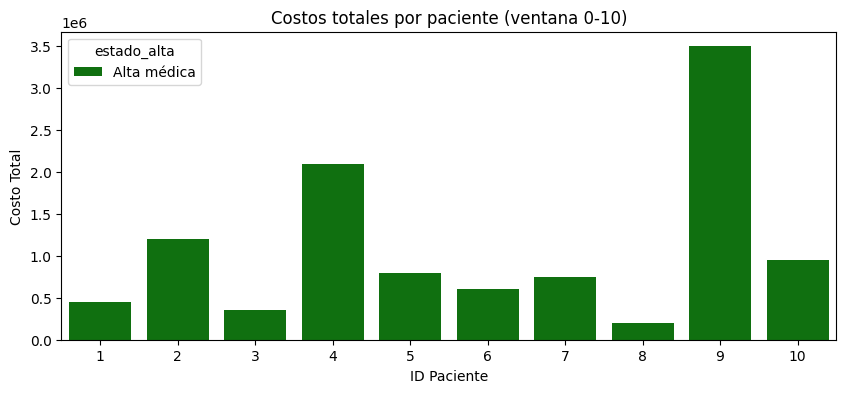

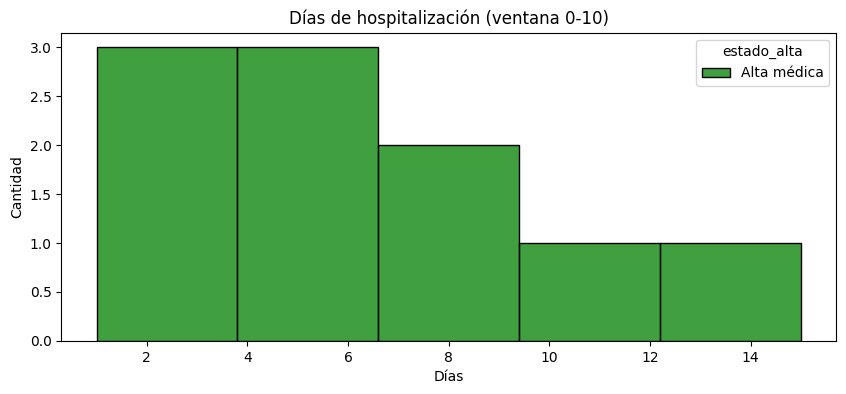

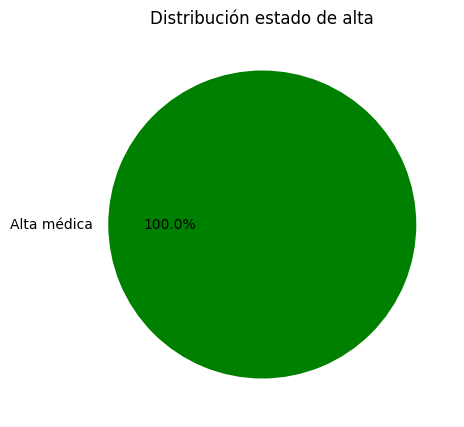


📦 Ventana 10-20 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
11,12,Roberto,Flores,65,Neurología,Parkinson,10,1300000,Alta médica
18,19,Beatriz,Herrera,62,Cardiología,Insuficiencia cardíaca,11,1450000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 12 (Roberto Flores): Alta médica | Días: 10 | Costo: $1300000
- Paciente 19 (Beatriz Herrera): Alta médica | Días: 11 | Costo: $1450000


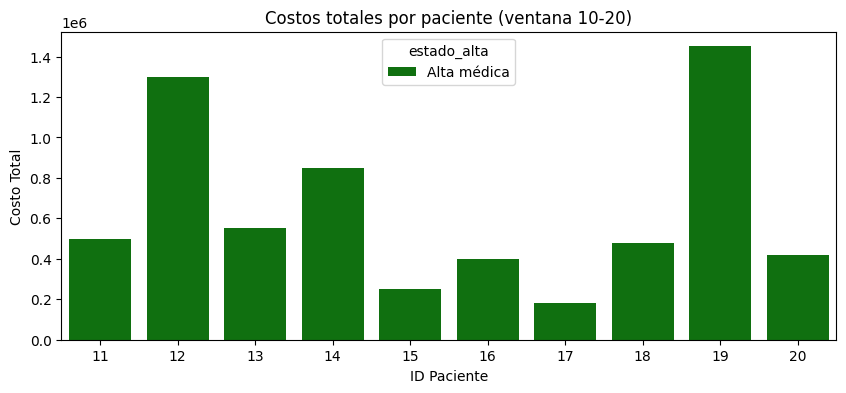

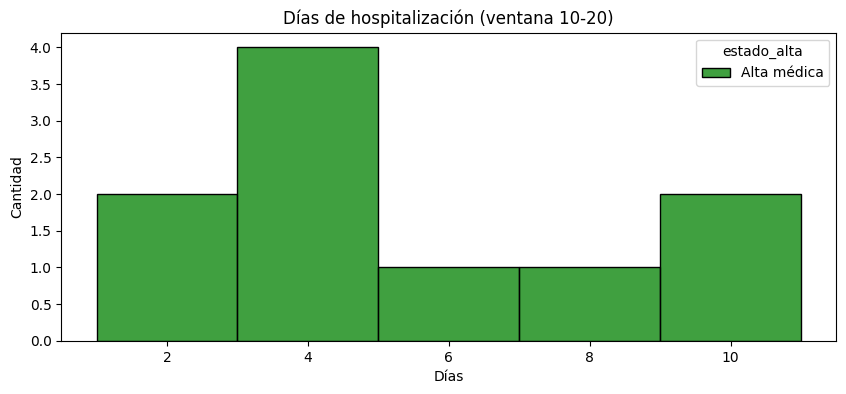

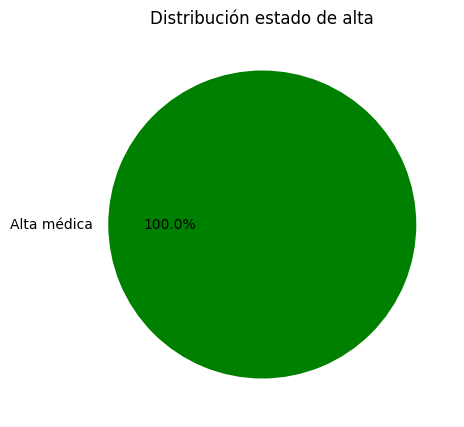


📦 Ventana 20-30 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
20,21,Soledad,Ramírez,54,Oncología,Quimioterapia,8,2800000,Alta médica
23,24,Rodrigo,Medina,59,Neurología,Epilepsia,9,980000,Alta médica
29,30,Sergio,Morales,51,Gastroenterología,Hepatitis,8,920000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 21 (Soledad Ramírez): Alta médica | Días: 8 | Costo: $2800000
- Paciente 24 (Rodrigo Medina): Alta médica | Días: 9 | Costo: $980000
- Paciente 30 (Sergio Morales): Alta médica | Días: 8 | Costo: $920000


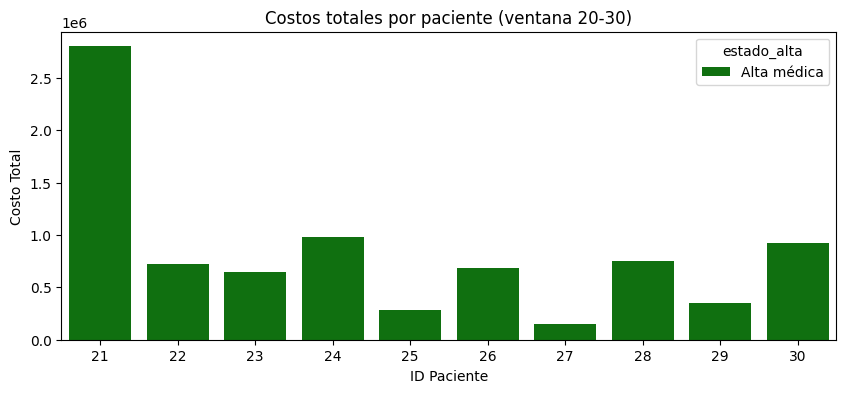

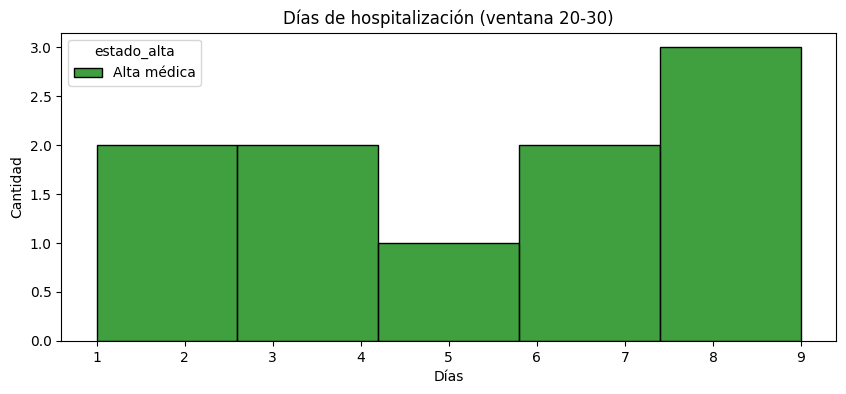

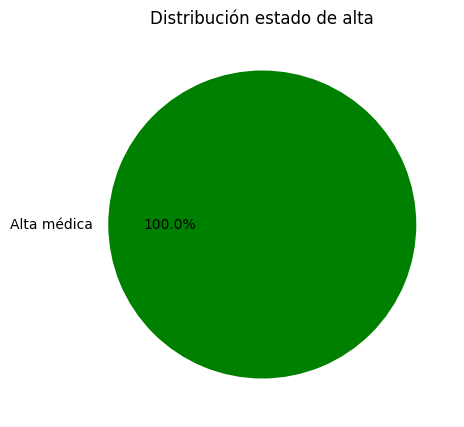


📦 Ventana 30-40 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
32,33,Carolina,Bravo,53,Oncología,Cáncer colorrectal,18,4200000,Alta médica
35,36,Cristián,Romero,74,Neurología,Demencia senil,14,1680000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 33 (Carolina Bravo): Alta médica | Días: 18 | Costo: $4200000
- Paciente 36 (Cristián Romero): Alta médica | Días: 14 | Costo: $1680000


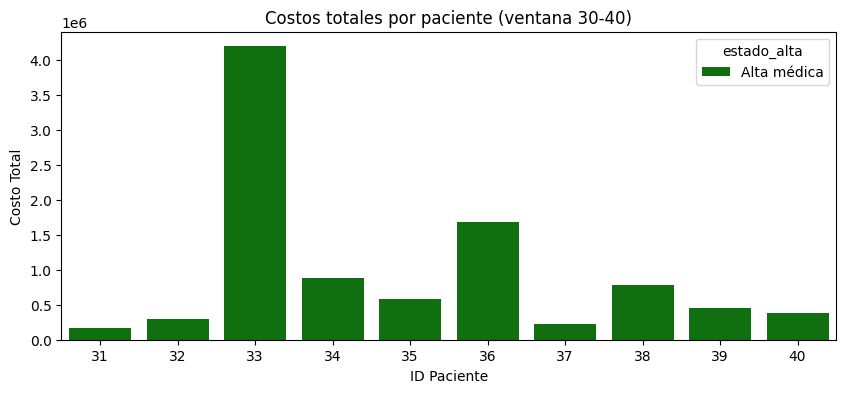

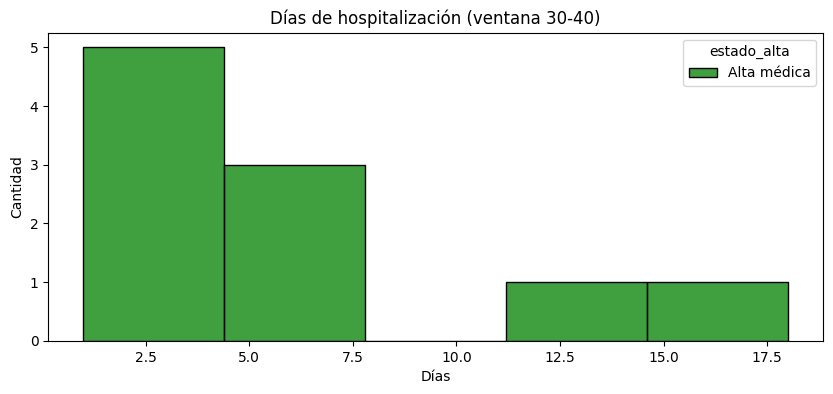

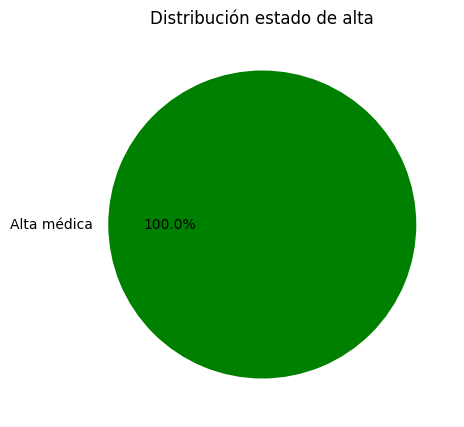


📦 Ventana 40-50 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
41,42,Antonio,Valdés,58,Cardiología,Fibrilación auricular,9,1150000,Alta médica
44,45,Viviana,Maldonado,50,Oncología,Mastectomía,10,2650000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 42 (Antonio Valdés): Alta médica | Días: 9 | Costo: $1150000
- Paciente 45 (Viviana Maldonado): Alta médica | Días: 10 | Costo: $2650000


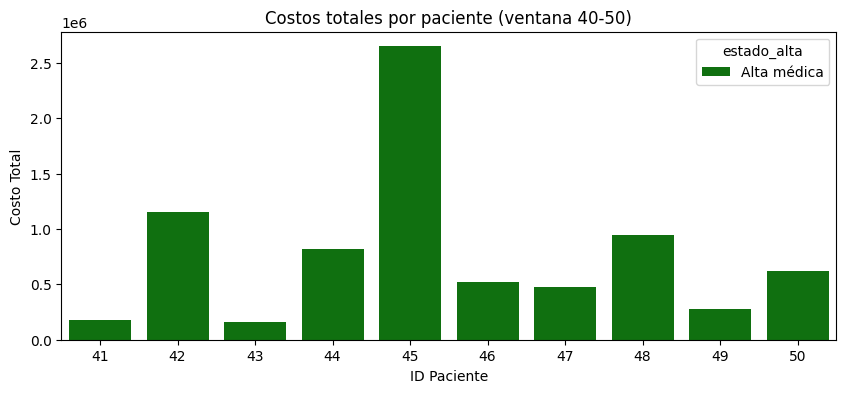

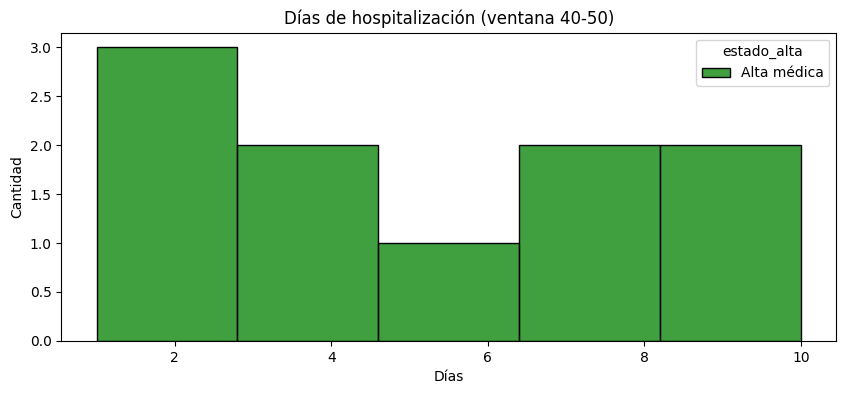

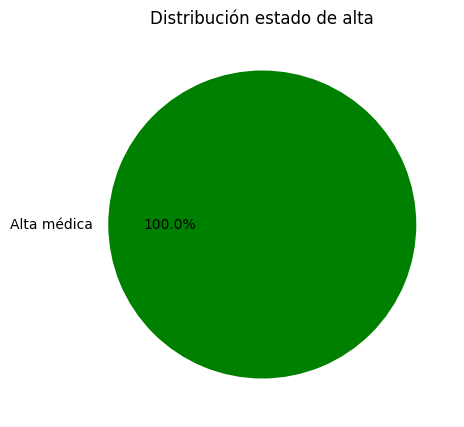


📦 Ventana 50-60 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
56,57,Andrea,Loyola,48,Oncología,Radioterapia,12,3100000,Alta médica
58,59,Pilar,Arias,56,Gastroenterología,Pancreatitis,9,1080000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 57 (Andrea Loyola): Alta médica | Días: 12 | Costo: $3100000
- Paciente 59 (Pilar Arias): Alta médica | Días: 9 | Costo: $1080000


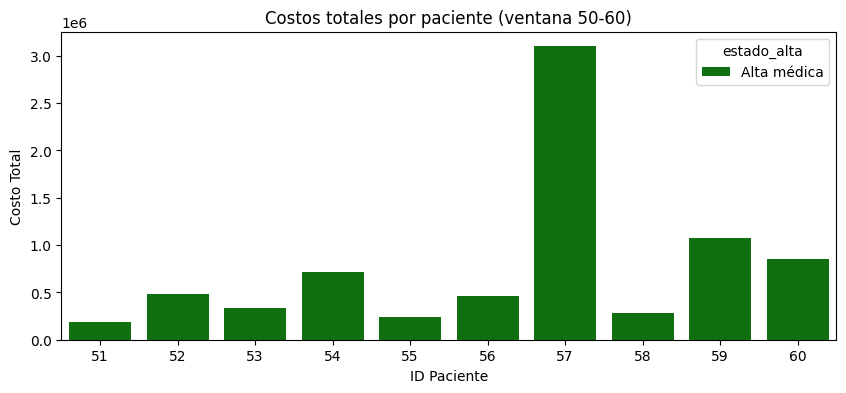

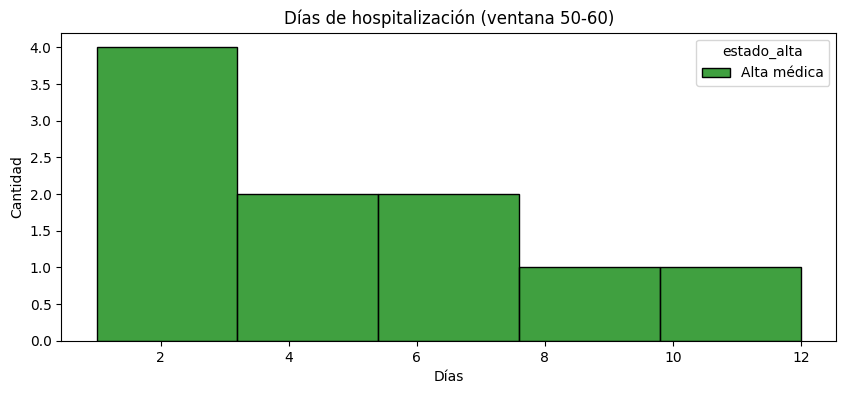

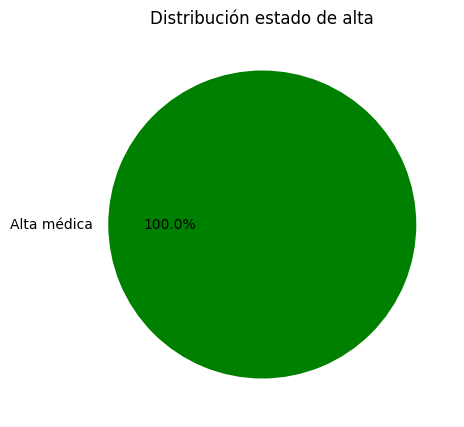


📦 Ventana 60-70 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
68,69,Silvia,Riquelme,47,Oncología,Linfoma,16,3800000,Alta médica
63,64,Fernando,Briceño,65,Urología,Cáncer de próstata,11,2200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 69 (Silvia Riquelme): Alta médica | Días: 16 | Costo: $3800000
- Paciente 64 (Fernando Briceño): Alta médica | Días: 11 | Costo: $2200000


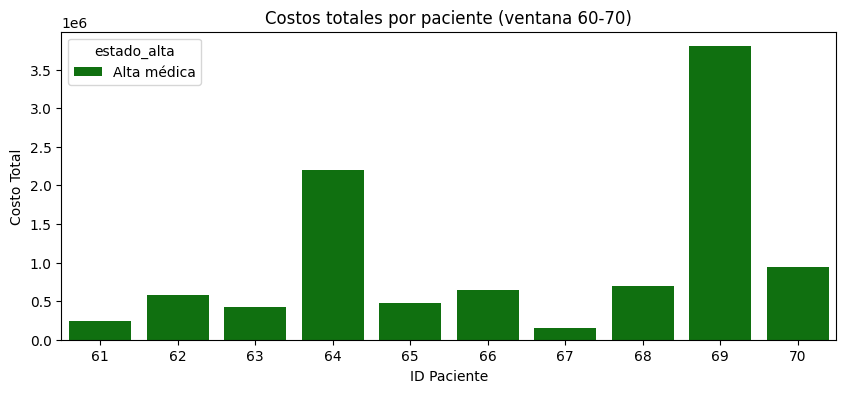

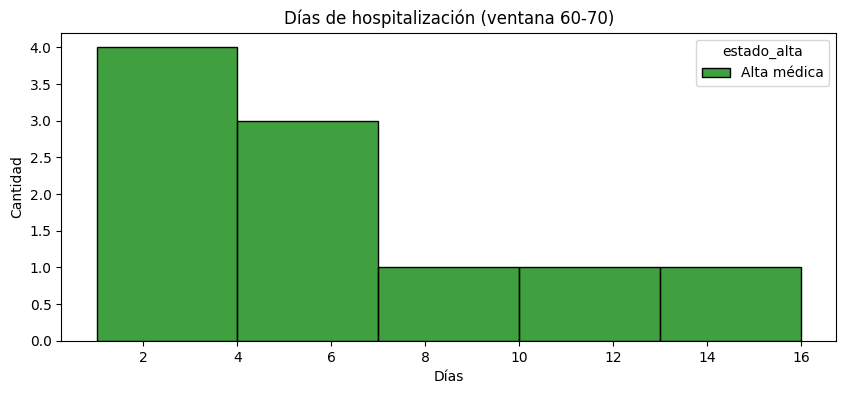

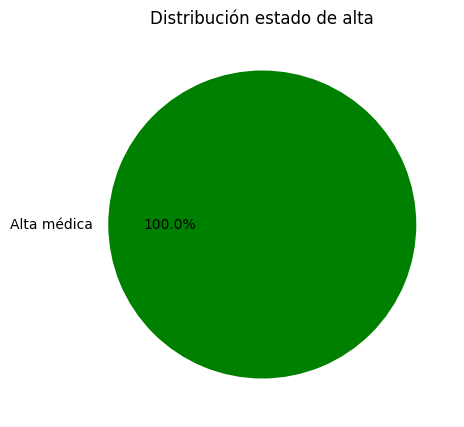


📦 Ventana 70-80 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
77,78,Jorge,Marchant,61,Cardiología,Bypass coronario,14,4500000,Alta médica
78,79,Mónica,Ulloa,33,Dermatología,Melanoma,6,1200000,Fallecido
79,80,Felipe,Espejo,70,Medicina Interna,Insuficiencia renal,13,2800000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 78 (Jorge Marchant): Alta médica | Días: 14 | Costo: $4500000
- Paciente 79 (Mónica Ulloa): Fallecido | Días: 6 | Costo: $1200000
- Paciente 80 (Felipe Espejo): Alta médica | Días: 13 | Costo: $2800000


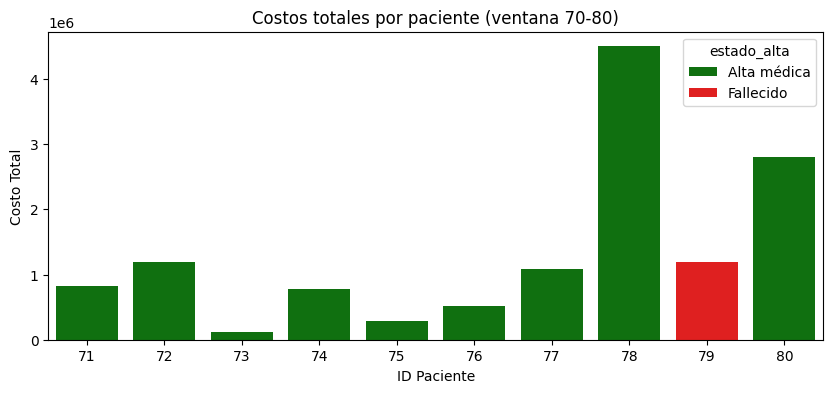

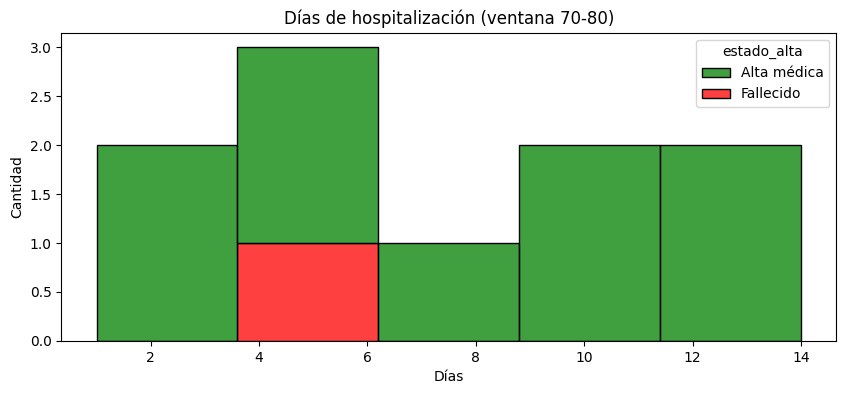

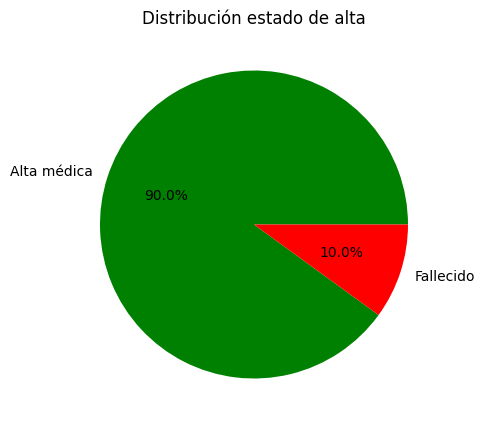


📦 Ventana 80-90 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
83,84,Rodrigo,Santander,67,Oncología,Cáncer de pulmón,19,4800000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 84 (Rodrigo Santander): Alta médica | Días: 19 | Costo: $4800000


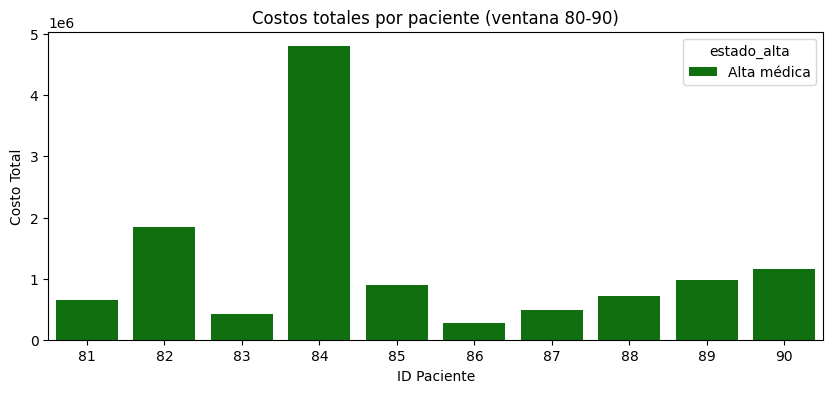

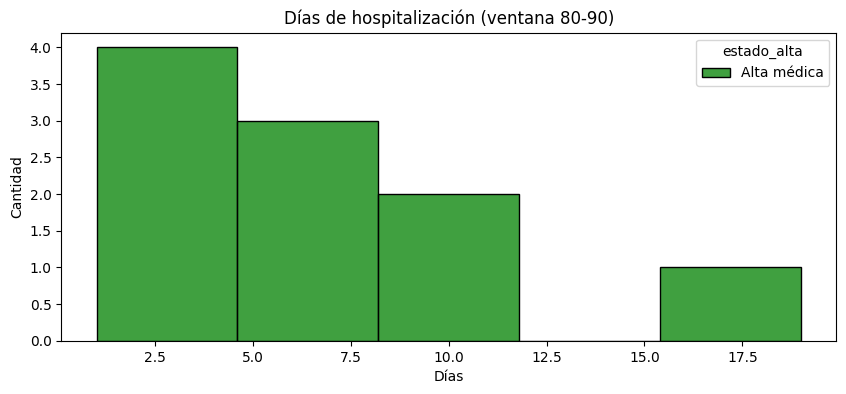

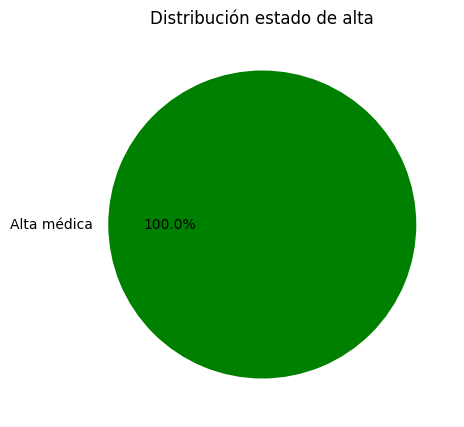


📦 Ventana 90-100 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
94,95,Gloria,Herrera,54,Oncología,Cáncer gástrico,21,5200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 95 (Gloria Herrera): Alta médica | Días: 21 | Costo: $5200000


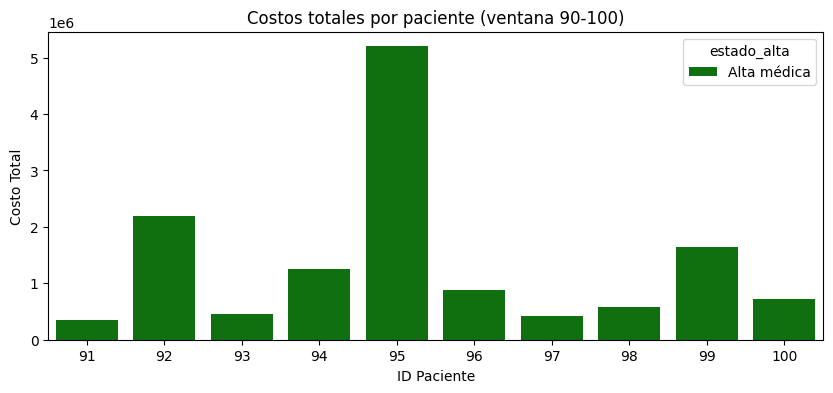

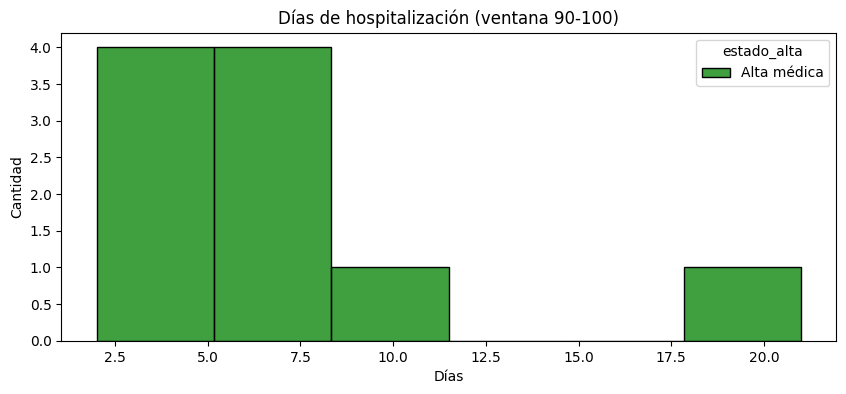

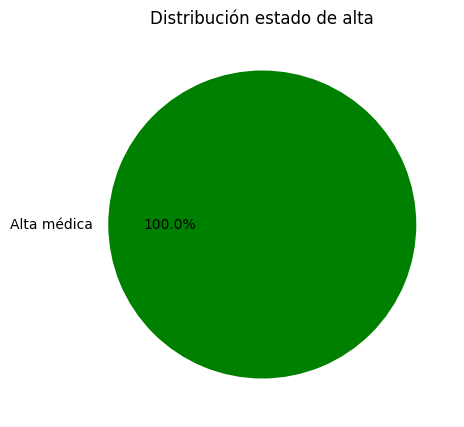


📦 Ventana 100-110 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
107,108,Raúl,Guerrero,58,Oncología,Leucemia,18,4500000,Alta médica
102,103,Verónica,Jiménez,28,Medicina Interna,Anorexia nerviosa,15,1800000,Alta médica
101,102,Álvaro,Mendez,62,Cardiología,Aneurisma aórtico,12,3200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 108 (Raúl Guerrero): Alta médica | Días: 18 | Costo: $4500000
- Paciente 103 (Verónica Jiménez): Alta médica | Días: 15 | Costo: $1800000
- Paciente 102 (Álvaro Mendez): Alta médica | Días: 12 | Costo: $3200000


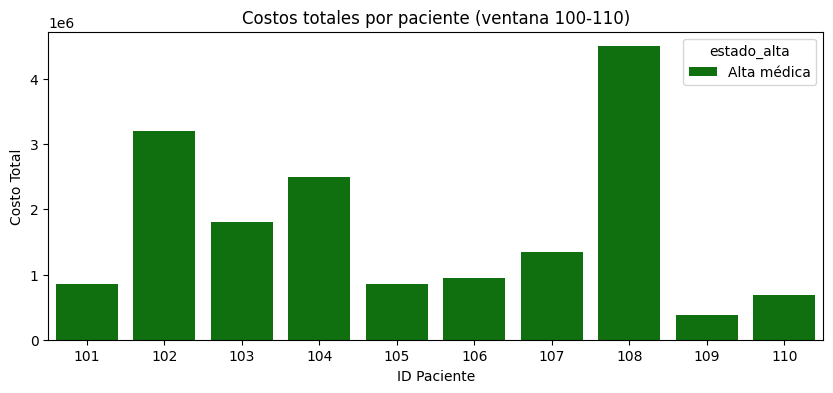

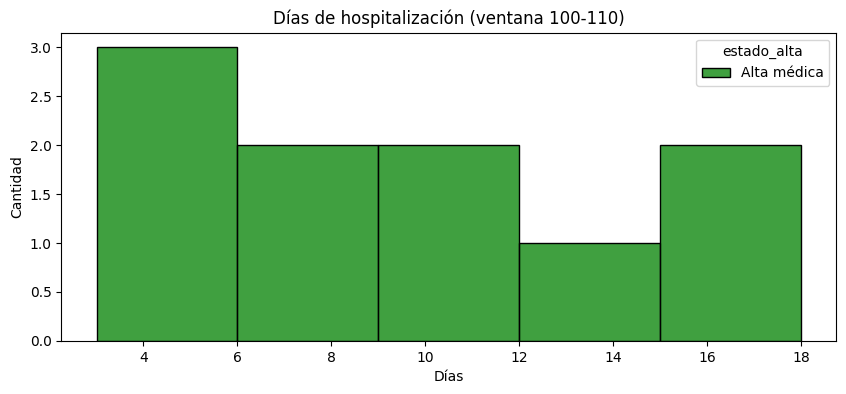

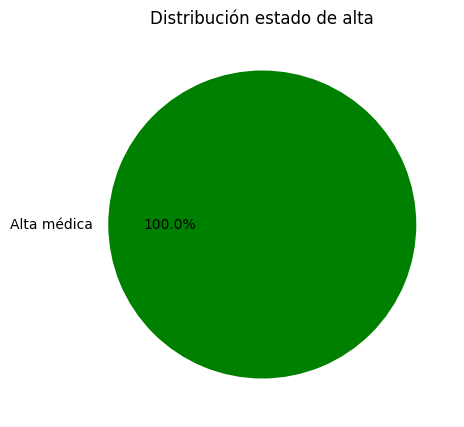


📦 Ventana 110-120 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
118,119,Constanza,Arias,34,Oncología,Cáncer cervical,14,3800000,Alta médica
111,112,Cristian,Núñez,37,Cardiología,Endocarditis,13,2800000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 119 (Constanza Arias): Alta médica | Días: 14 | Costo: $3800000
- Paciente 112 (Cristian Núñez): Alta médica | Días: 13 | Costo: $2800000


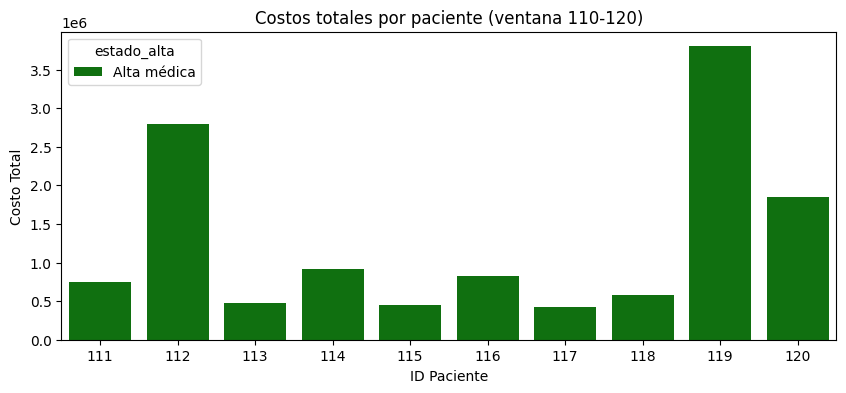

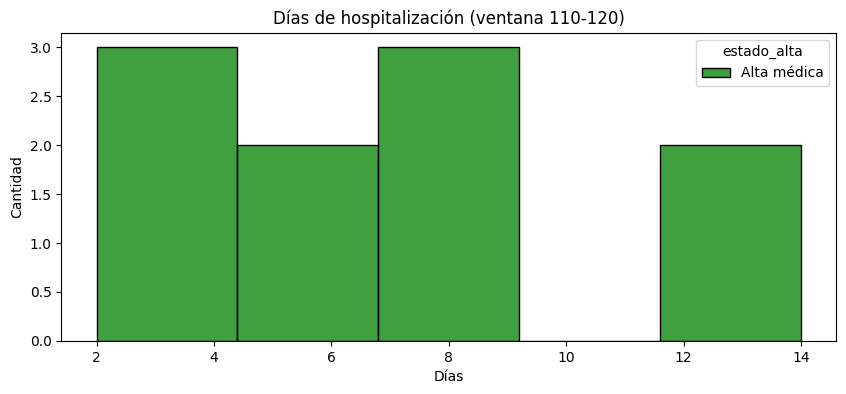

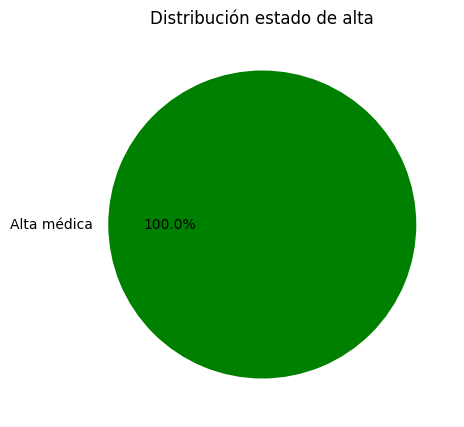


📦 Ventana 120-130 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
125,126,Ricardo,Maldonado,44,Neurología,Esclerosis lateral,16,3500000,Fallecido
129,130,Rodrigo,Salinas,65,Oncología,Cáncer pancreático,22,6800000,Fallecido


⚠️ Alertas de la ventana:
- Paciente 126 (Ricardo Maldonado): Fallecido | Días: 16 | Costo: $3500000
- Paciente 130 (Rodrigo Salinas): Fallecido | Días: 22 | Costo: $6800000


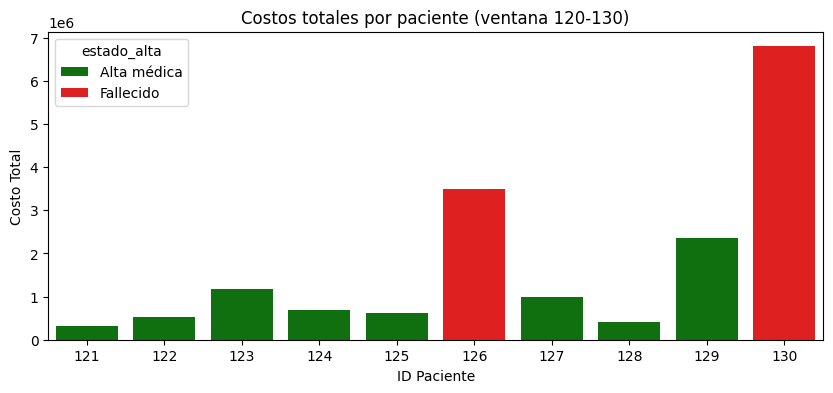

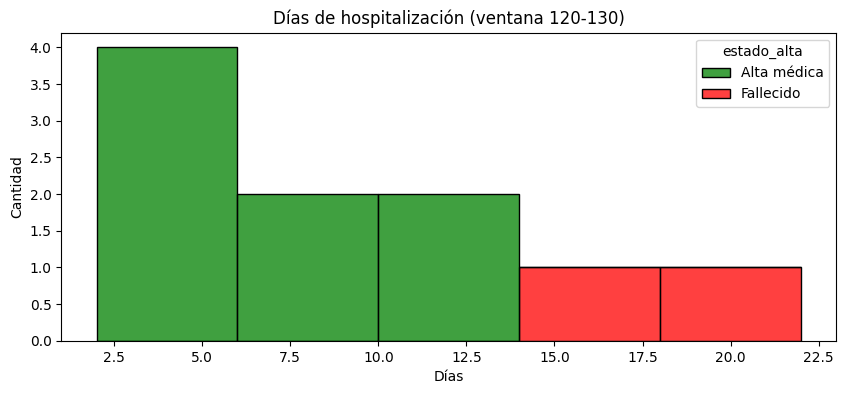

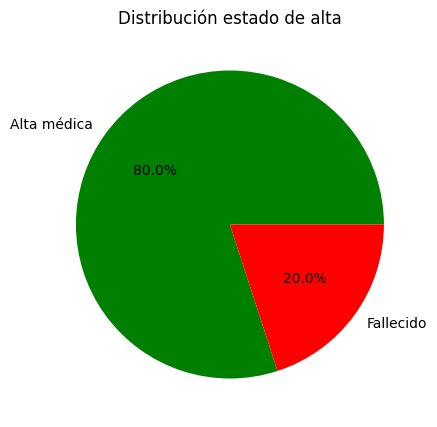


📦 Ventana 130-140 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
139,140,Álvaro,Henriquez,58,Oncología,Sarcoma,20,5500000,Alta médica
135,136,Tomás,Loyola,49,Cardiología,Tromboembolia pulmonar,14,3200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 140 (Álvaro Henriquez): Alta médica | Días: 20 | Costo: $5500000
- Paciente 136 (Tomás Loyola): Alta médica | Días: 14 | Costo: $3200000


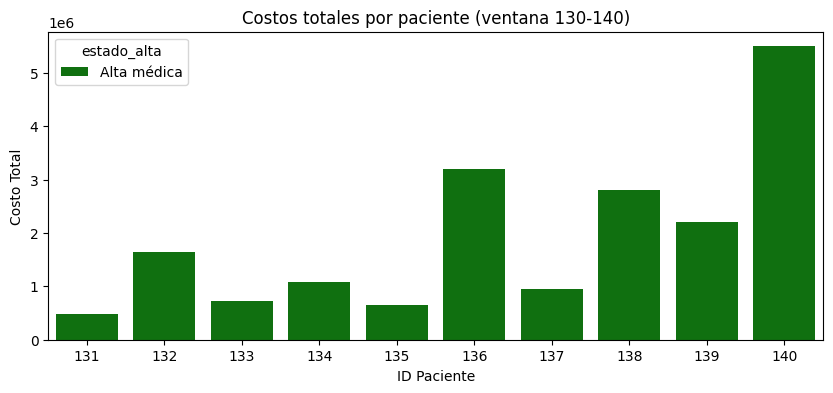

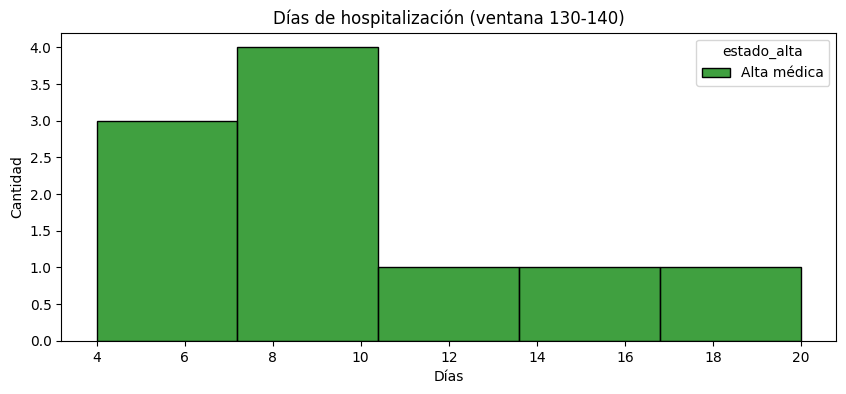

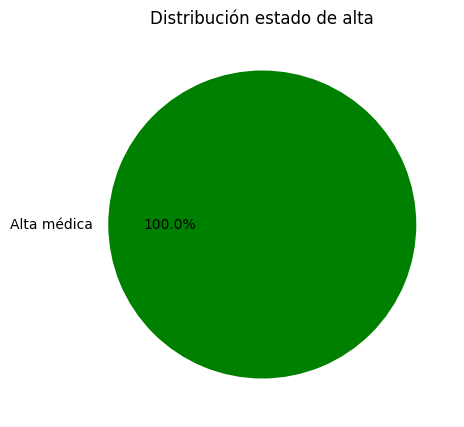


📦 Ventana 140-150 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
147,148,Roberto,Villalobos,64,Gastroenterología,Cáncer hepático,16,4800000,Fallecido
141,142,Manuel,Pizarro,67,Medicina Interna,Insuficiencia cardíaca,13,2650000,Fallecido
149,150,Ignacio,Leiva,72,Oncología,Mieloma múltiple,19,5200000,Alta médica
140,141,Daniela,Briceño,41,Ginecología,Cáncer ovario,15,4200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 148 (Roberto Villalobos): Fallecido | Días: 16 | Costo: $4800000
- Paciente 142 (Manuel Pizarro): Fallecido | Días: 13 | Costo: $2650000
- Paciente 150 (Ignacio Leiva): Alta médica | Días: 19 | Costo: $5200000
- Paciente 141 (Daniela Briceño): Alta médica | Días: 15 | Costo: $4200000


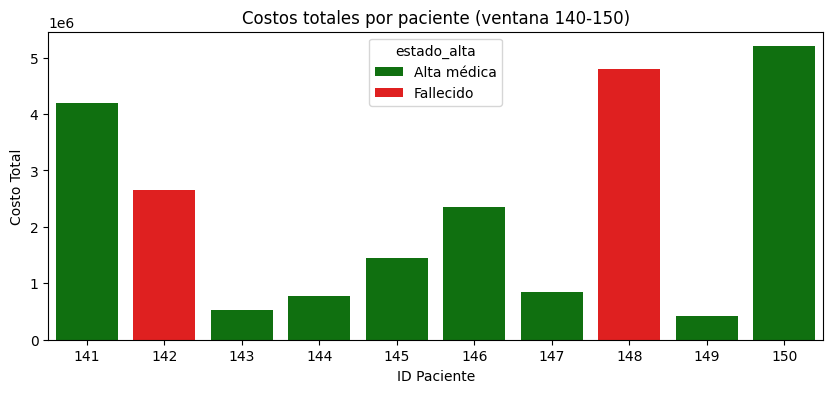

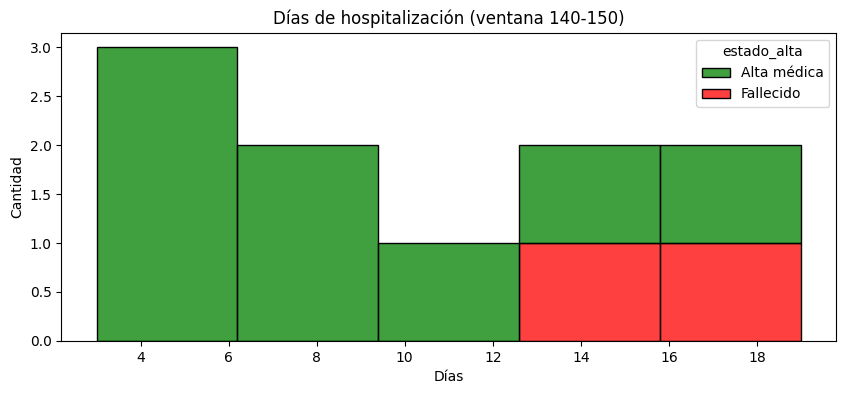

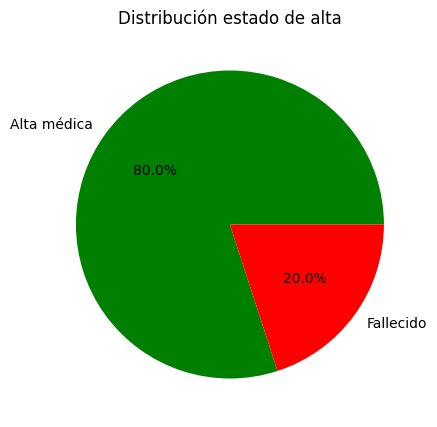


📦 Ventana 150-160 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
153,154,Gonzalo,Ulloa,59,Cardiología,Bypass triple,15,4500000,Alta médica
159,160,Ricardo,Cortez,26,Traumatología,Lesión medular,18,5500000,Alta médica
157,158,Mario,Pereira,37,Neurología,Epilepsia refractaria,14,3200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 154 (Gonzalo Ulloa): Alta médica | Días: 15 | Costo: $4500000
- Paciente 160 (Ricardo Cortez): Alta médica | Días: 18 | Costo: $5500000
- Paciente 158 (Mario Pereira): Alta médica | Días: 14 | Costo: $3200000


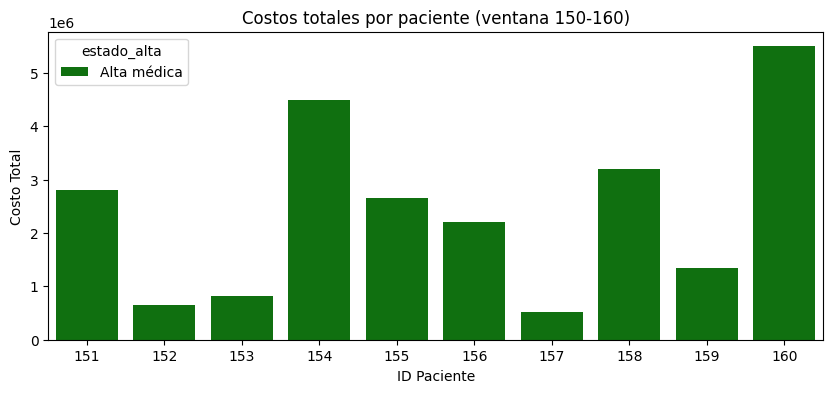

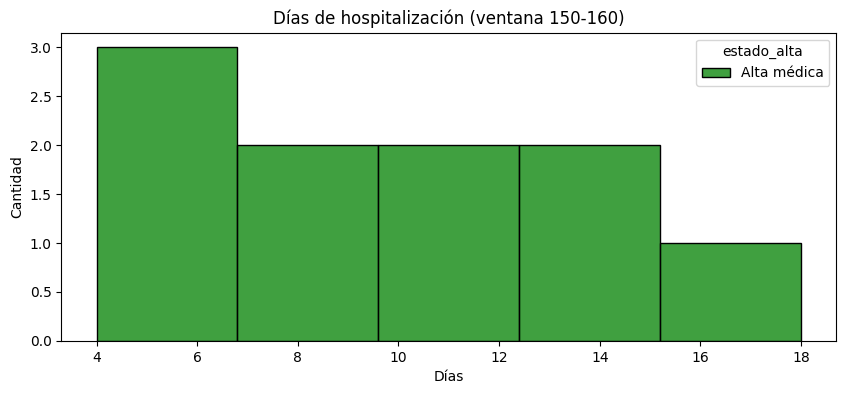

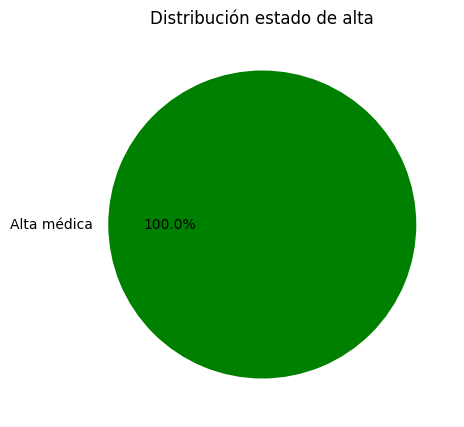


📦 Ventana 160-170 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
165,166,Carlos,Morales,47,Neurología,Huntington,16,4200000,Fallecido
163,164,Pablo,Valenzuela,56,Cardiología,Cardiomiopatía,13,3500000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 166 (Carlos Morales): Fallecido | Días: 16 | Costo: $4200000
- Paciente 164 (Pablo Valenzuela): Alta médica | Días: 13 | Costo: $3500000


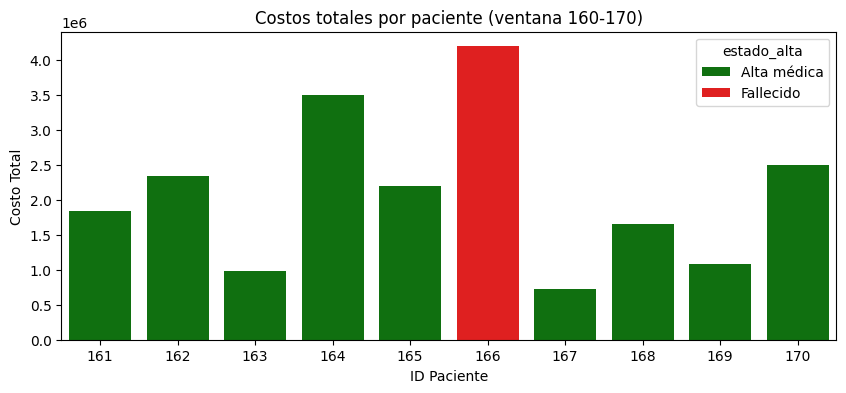

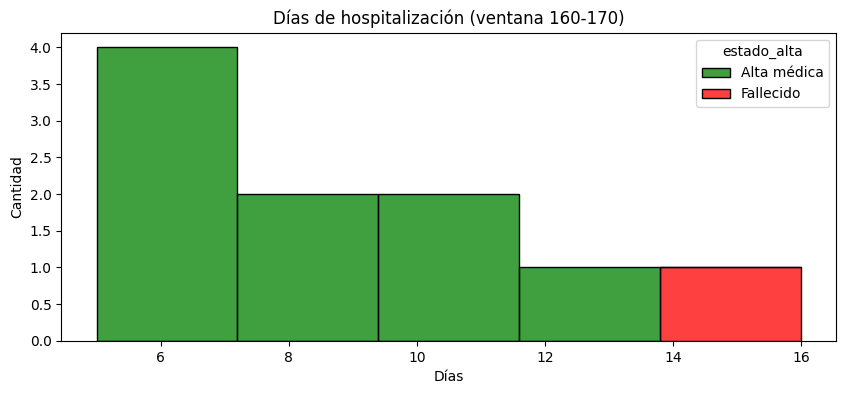

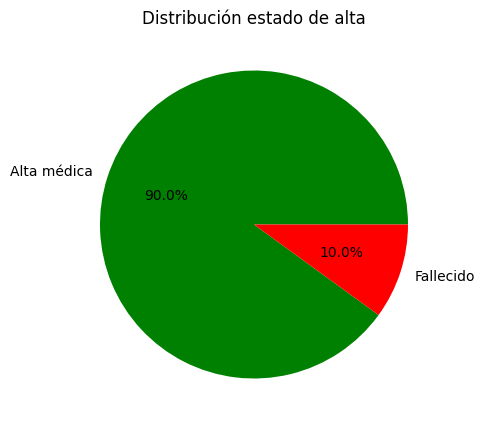


📦 Ventana 170-180 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
177,178,Raúl,Donoso,73,Medicina Interna,Insuficiencia renal crónica,14,3800000,Fallecido
172,173,Carolina,Olivares,49,Oncología,Linfoma no Hodgkin,17,4800000,Alta médica
170,171,Soledad,Guerrero,42,Cardiología,Valvulopatía múltiple,12,3200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 178 (Raúl Donoso): Fallecido | Días: 14 | Costo: $3800000
- Paciente 173 (Carolina Olivares): Alta médica | Días: 17 | Costo: $4800000
- Paciente 171 (Soledad Guerrero): Alta médica | Días: 12 | Costo: $3200000


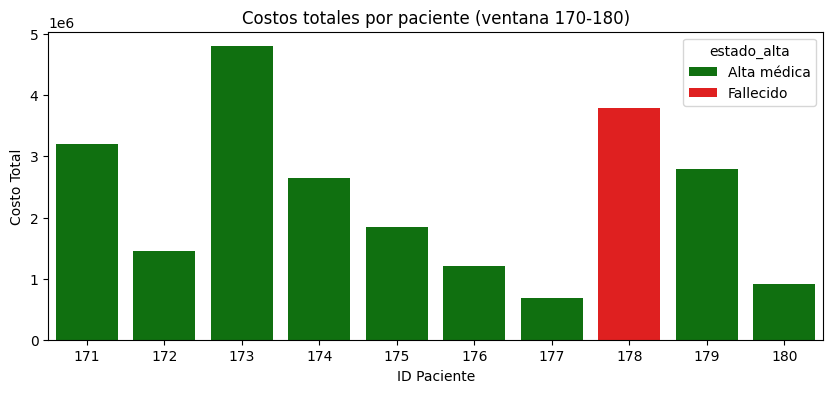

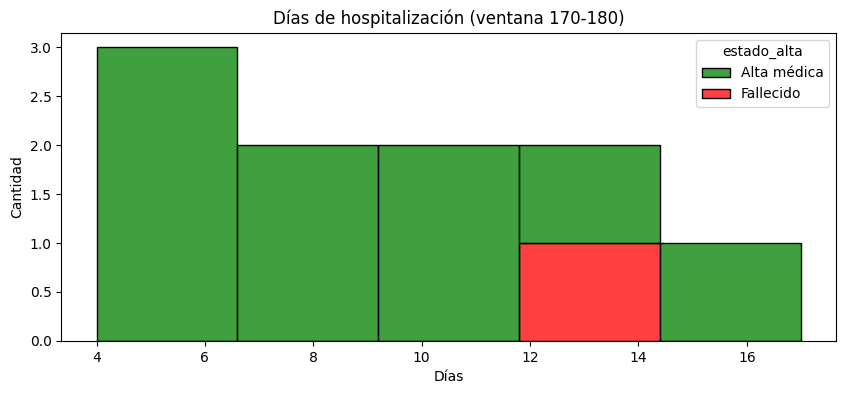

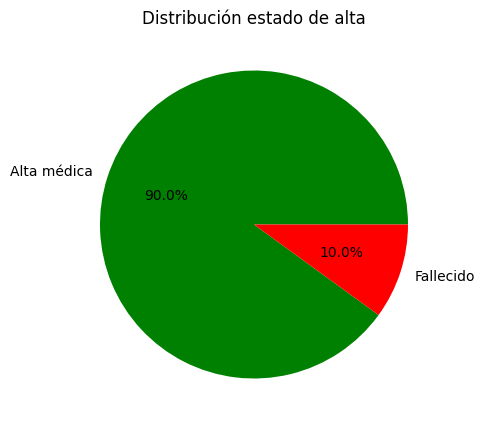


📦 Ventana 180-190 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
187,188,Ricardo,Salinas,55,Oncología,Tumor cerebral,20,6500000,Fallecido
181,182,Felipe,Cáceres,48,Gastroenterología,Carcinoma hepatocelular,15,4500000,Fallecido
189,190,Gonzalo,Gallegos,46,Traumatología,Amputación traumática,21,7200000,Alta médica
185,186,Carlos,Varela,64,Cardiología,Tetralogía de Fallot,16,5200000,Alta médica
183,184,Mario,Maldonado,59,Neurología,Mielitis transversa,12,3200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 188 (Ricardo Salinas): Fallecido | Días: 20 | Costo: $6500000
- Paciente 182 (Felipe Cáceres): Fallecido | Días: 15 | Costo: $4500000
- Paciente 190 (Gonzalo Gallegos): Alta médica | Días: 21 | Costo: $7200000
- Paciente 186 (Carlos Varela): Alta médica | Días: 16 | Costo: $5200000
- Paciente 184 (Mario Maldonado): Alta médica | Días: 12 | Costo: $3200000


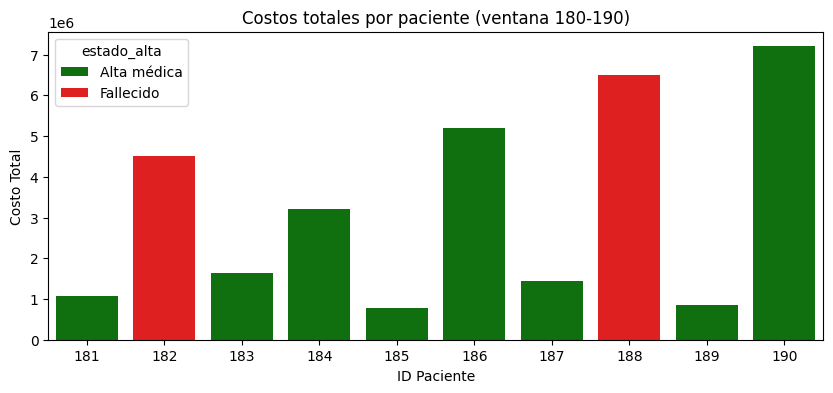

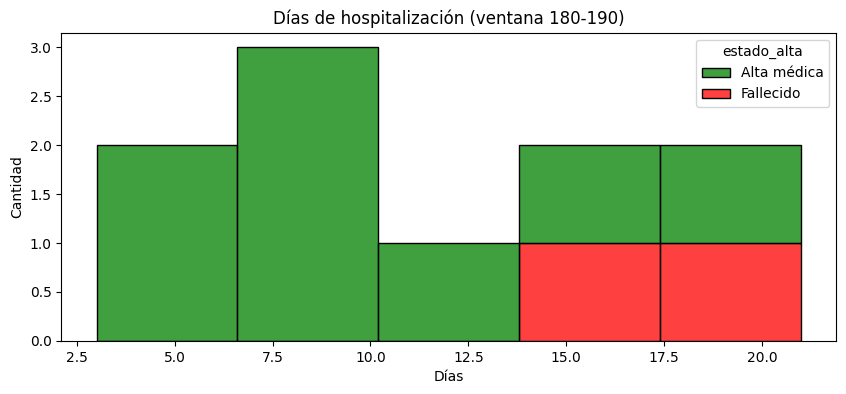

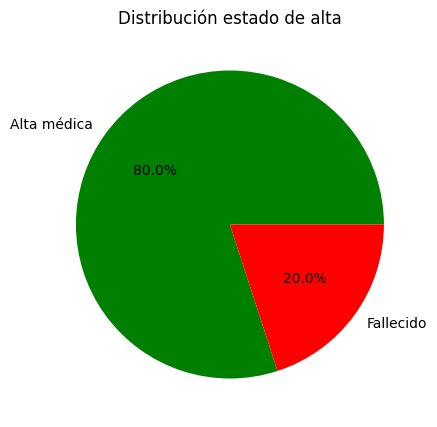


📦 Ventana 190-200 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
197,198,Carlos,Henriquez,56,Oncología,Cáncer de esófago,18,5500000,Fallecido
192,193,Carmen,Urrutia,49,Gastroenterología,Cirrosis alcohólica,13,3500000,Fallecido
193,194,Pablo,Loyola,71,Cardiología,Aneurisma cerebral,11,3200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 198 (Carlos Henriquez): Fallecido | Días: 18 | Costo: $5500000
- Paciente 193 (Carmen Urrutia): Fallecido | Días: 13 | Costo: $3500000
- Paciente 194 (Pablo Loyola): Alta médica | Días: 11 | Costo: $3200000


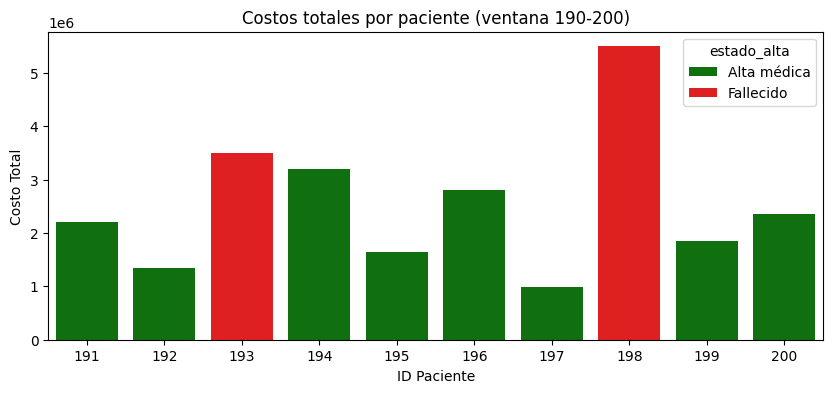

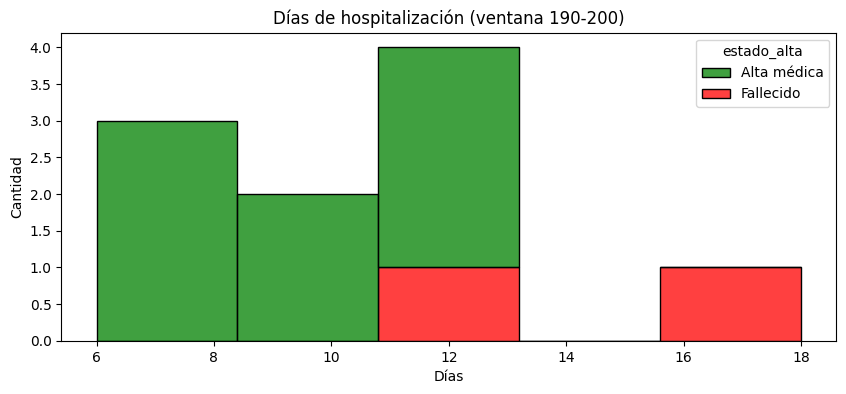

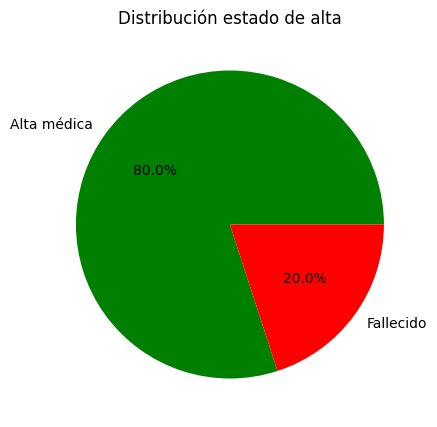


📦 Ventana 200-210 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
205,206,Felipe,Villalobos,63,Gastroenterología,Tumor pancreático,16,4800000,Fallecido
206,207,Andrea,Acevedo,31,Traumatología,Osteosarcoma,19,5800000,Alta médica
201,202,Rodrigo,Riquelme,54,Cardiología,Coartación aórtica,14,4200000,Alta médica
203,204,Eduardo,Paredes,48,Neurología,Distrofia muscular,15,3800000,Alta médica
209,210,Mario,Araya,69,Cardiología,Estenosis aórtica,12,3500000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 206 (Felipe Villalobos): Fallecido | Días: 16 | Costo: $4800000
- Paciente 207 (Andrea Acevedo): Alta médica | Días: 19 | Costo: $5800000
- Paciente 202 (Rodrigo Riquelme): Alta médica | Días: 14 | Costo: $4200000
- Paciente 204 (Eduardo Paredes): Alta médica | Días: 15 | Costo: $3800000
- Paciente 210 (Mario Araya): Alta médica | Días: 12 | Costo: $3500000


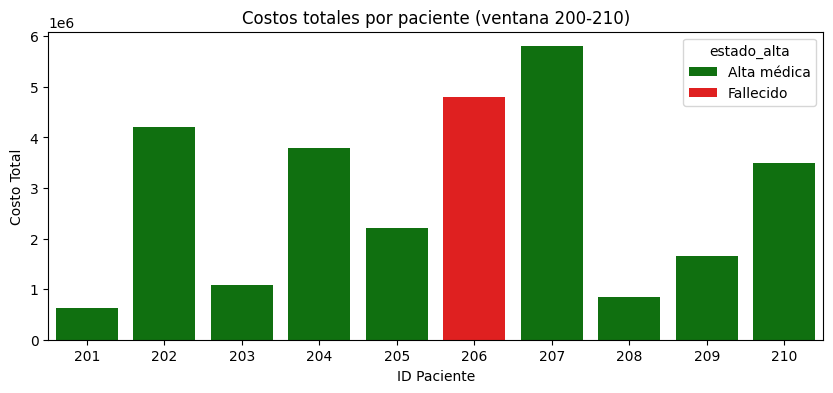

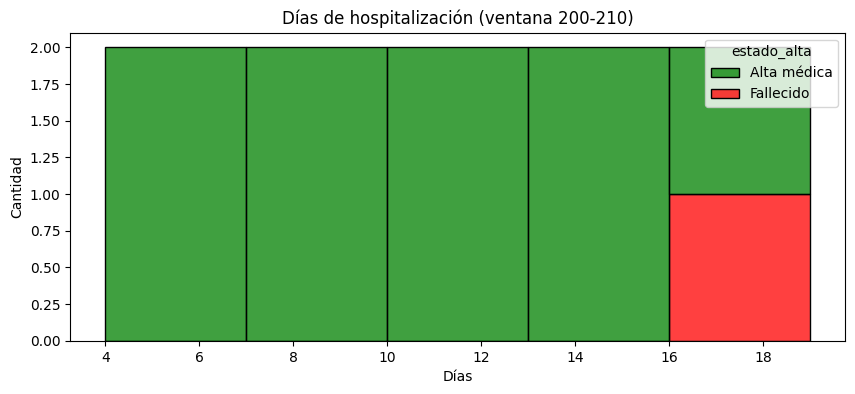

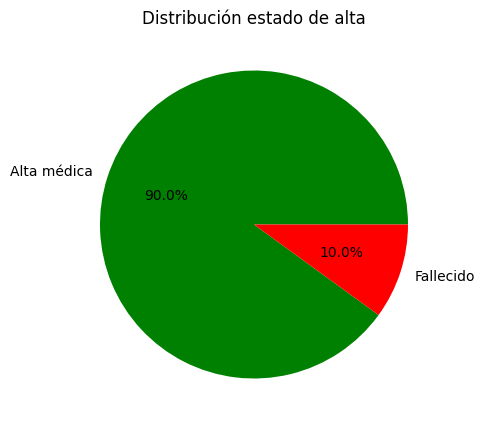


📦 Ventana 210-220 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
219,220,Eduardo,Salazar,72,Neurología,Demencia frontotemporal,16,4800000,Fallecido
212,213,Carmen,Espejo,39,Neurología,Corea de Huntington,13,3200000,Fallecido
217,218,Ricardo,Cortez,61,Gastroenterología,Colangiocarcinoma,14,4200000,Fallecido
211,212,Sergio,Ulloa,53,Oncología,Cáncer renal,17,4500000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 220 (Eduardo Salazar): Fallecido | Días: 16 | Costo: $4800000
- Paciente 213 (Carmen Espejo): Fallecido | Días: 13 | Costo: $3200000
- Paciente 218 (Ricardo Cortez): Fallecido | Días: 14 | Costo: $4200000
- Paciente 212 (Sergio Ulloa): Alta médica | Días: 17 | Costo: $4500000


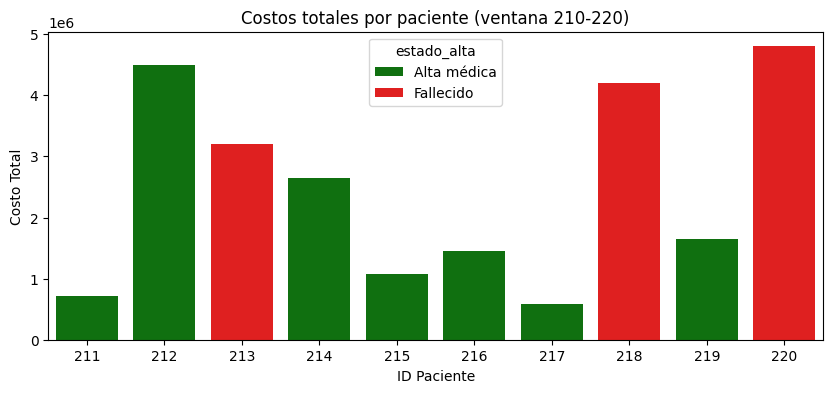

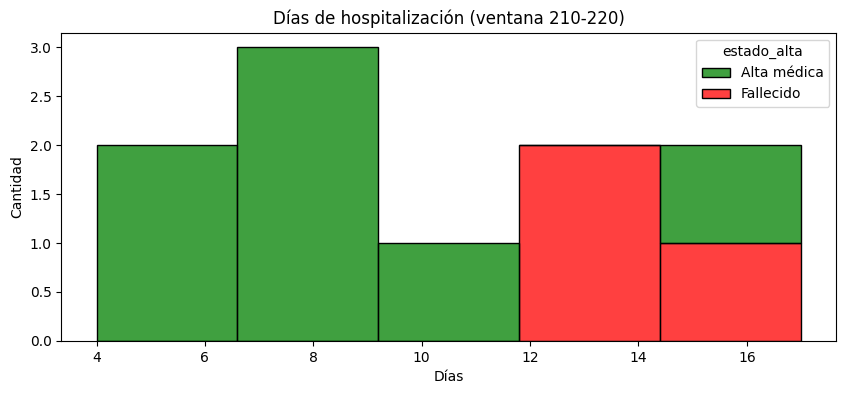

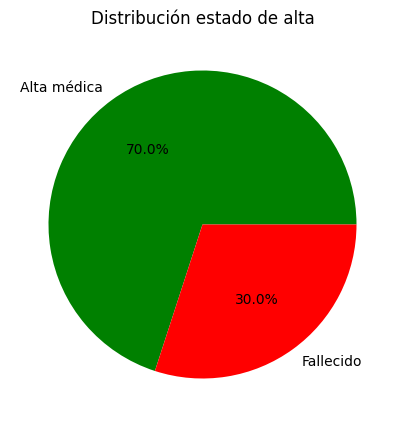


📦 Ventana 220-230 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
223,224,Carlos,Morales,38,Oncología,Tumor espinal,15,4500000,Alta médica
228,229,Patricia,Guerrero,42,Neurología,Síndrome de Guillain-Barré,14,3500000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 224 (Carlos Morales): Alta médica | Días: 15 | Costo: $4500000
- Paciente 229 (Patricia Guerrero): Alta médica | Días: 14 | Costo: $3500000


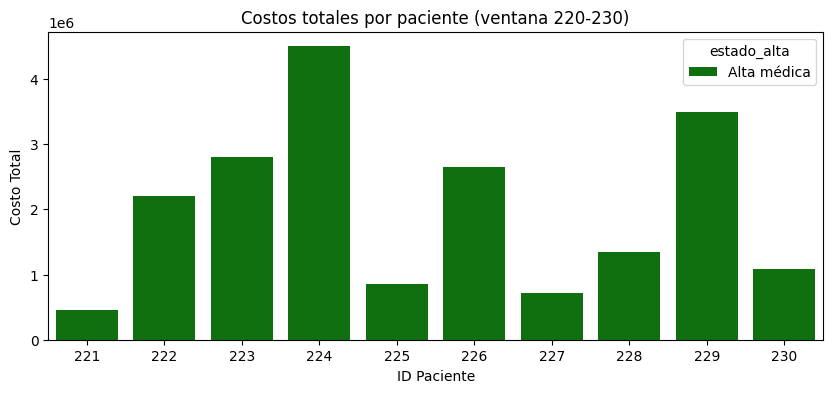

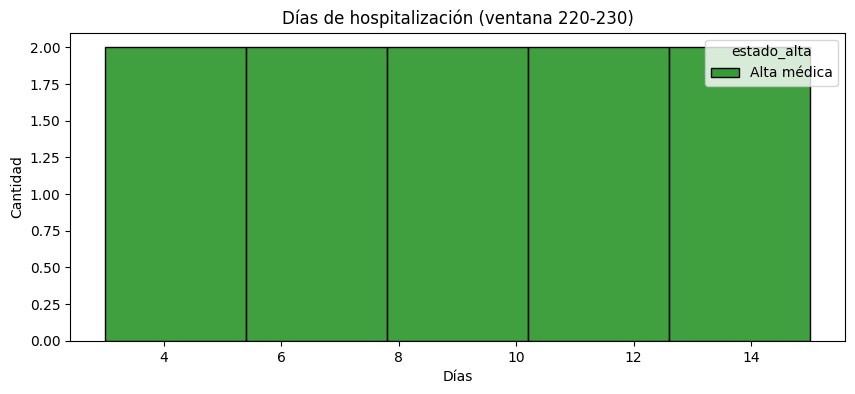

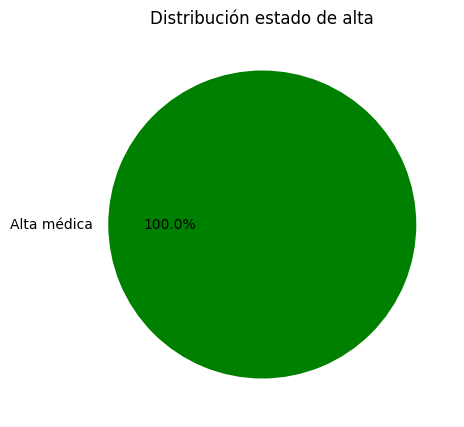


📦 Ventana 230-240 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
235,236,Carlos,Donoso,71,Oncología,Cáncer de vejiga,16,4800000,Alta médica
231,232,Felipe,Tapia,64,Traumatología,Osteomielitis,13,3200000,Alta médica
239,240,Ricardo,Cáceres,66,Urología,Tumor de Wilms,12,3200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 236 (Carlos Donoso): Alta médica | Días: 16 | Costo: $4800000
- Paciente 232 (Felipe Tapia): Alta médica | Días: 13 | Costo: $3200000
- Paciente 240 (Ricardo Cáceres): Alta médica | Días: 12 | Costo: $3200000


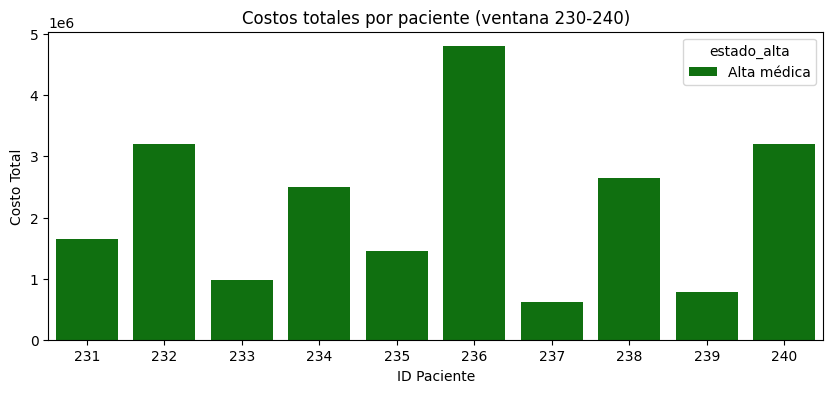

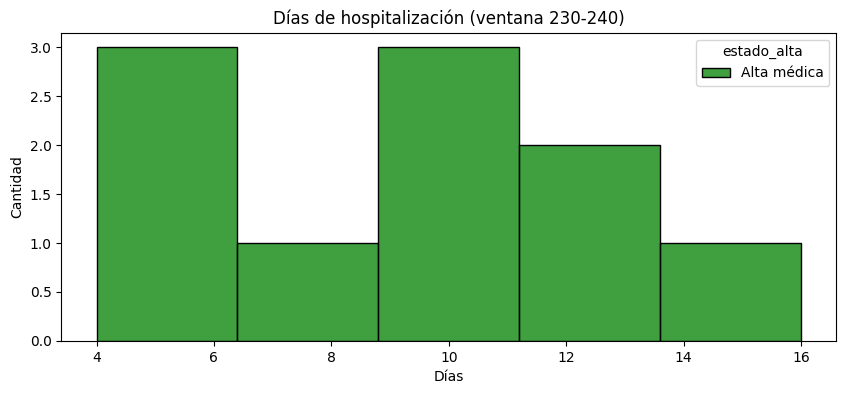

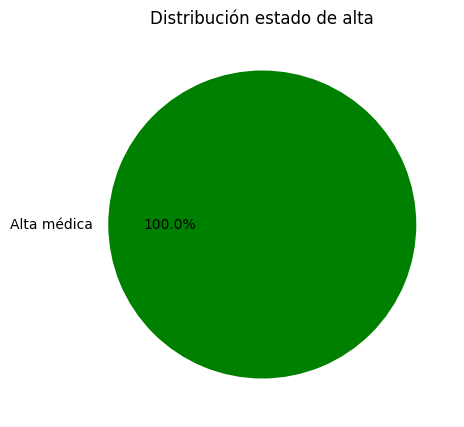


📦 Ventana 240-250 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
245,246,Gonzalo,Salinas,62,Neurología,Ataxia cerebelosa,15,3800000,Alta médica
247,248,Carlos,Gallegos,46,Traumatología,Fractura expuesta múltiple,17,4500000,Alta médica
242,243,Carmen,Sandoval,37,Medicina Interna,Poliarteritis nodosa,13,3200000,Alta médica
248,249,Patricia,Aravena,53,Oncología,Tumor neuroendocrino,14,4200000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 246 (Gonzalo Salinas): Alta médica | Días: 15 | Costo: $3800000
- Paciente 248 (Carlos Gallegos): Alta médica | Días: 17 | Costo: $4500000
- Paciente 243 (Carmen Sandoval): Alta médica | Días: 13 | Costo: $3200000
- Paciente 249 (Patricia Aravena): Alta médica | Días: 14 | Costo: $4200000


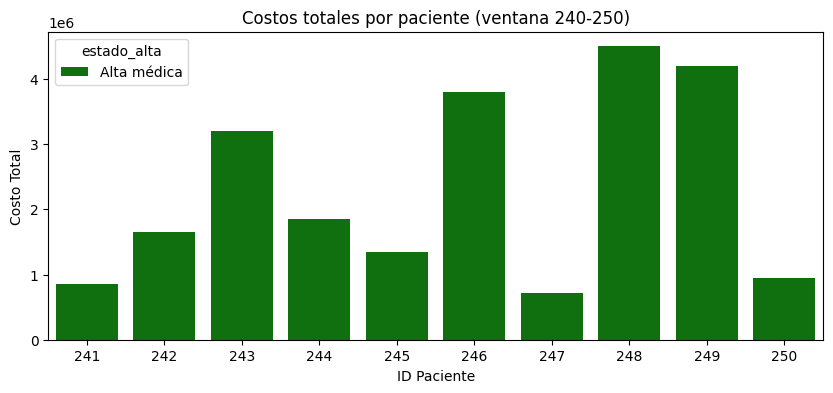

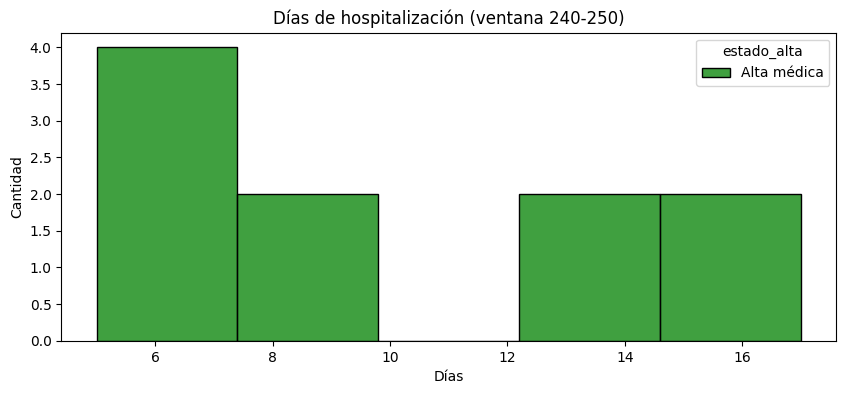

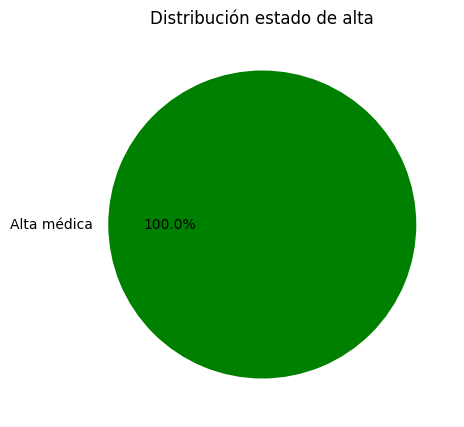


📦 Ventana 250-260 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
253,254,Fernando,Molina,57,Neurología,Leucodistrofia,16,4800000,Fallecido
250,251,Gloria,Urrutia,48,Cardiología,Síndrome de Eisenmenger,12,3500000,Fallecido
255,256,Pablo,Henriquez,71,Gastroenterología,Adenocarcinoma gástrico,15,4500000,Fallecido
259,260,Mario,Riquelme,68,Cardiología,Transposición grandes vasos,18,5800000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 254 (Fernando Molina): Fallecido | Días: 16 | Costo: $4800000
- Paciente 251 (Gloria Urrutia): Fallecido | Días: 12 | Costo: $3500000
- Paciente 256 (Pablo Henriquez): Fallecido | Días: 15 | Costo: $4500000
- Paciente 260 (Mario Riquelme): Alta médica | Días: 18 | Costo: $5800000


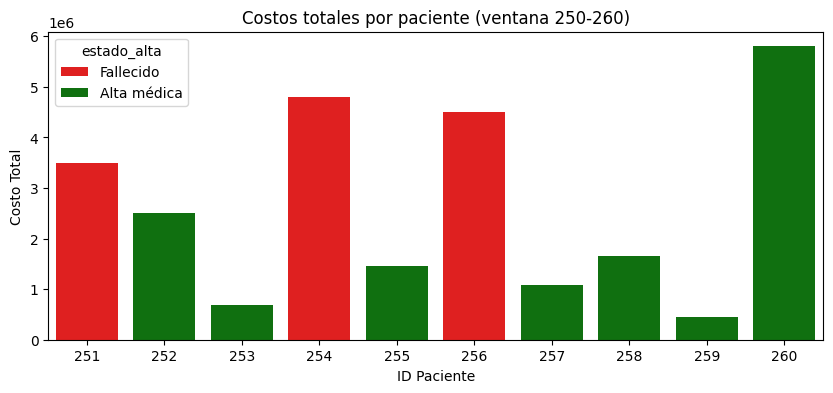

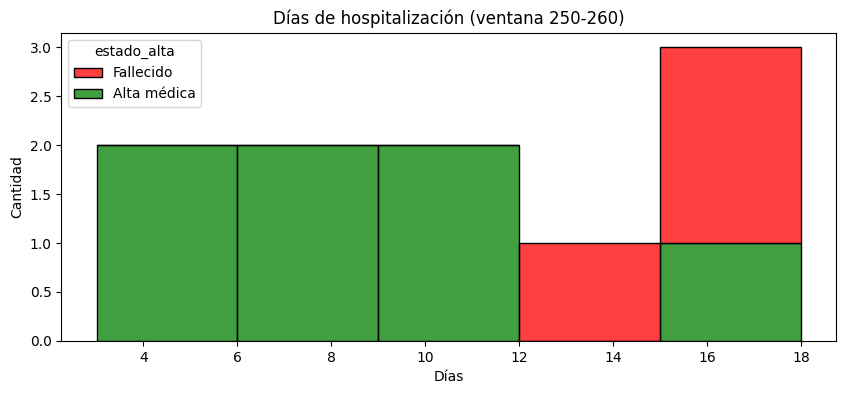

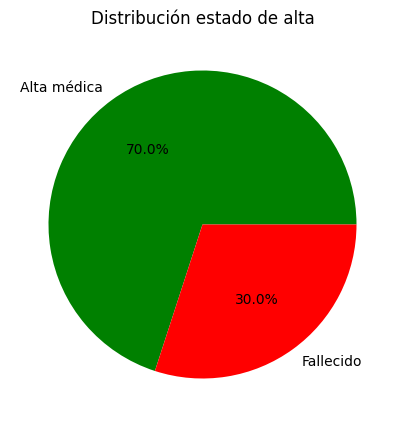


📦 Ventana 260-270 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
261,262,Ricardo,Paredes,49,Oncología,Mesotelioma pleural,19,5500000,Fallecido
262,263,Carmen,Sepúlveda,27,Neurología,Síndrome de Rett,13,3200000,Alta médica
265,266,Fernando,Leiva,63,Urología,Síndrome de Goodpasture,12,3200000,Alta médica
267,268,Pablo,Araya,51,Gastroenterología,Colangitis esclerosante,14,3800000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 262 (Ricardo Paredes): Fallecido | Días: 19 | Costo: $5500000
- Paciente 263 (Carmen Sepúlveda): Alta médica | Días: 13 | Costo: $3200000
- Paciente 266 (Fernando Leiva): Alta médica | Días: 12 | Costo: $3200000
- Paciente 268 (Pablo Araya): Alta médica | Días: 14 | Costo: $3800000


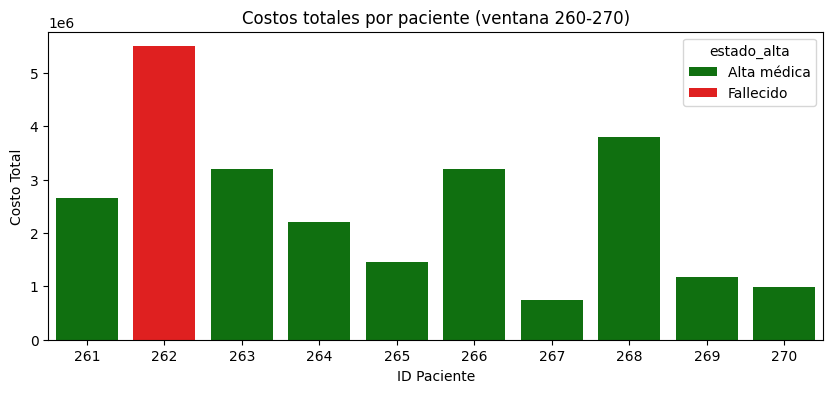

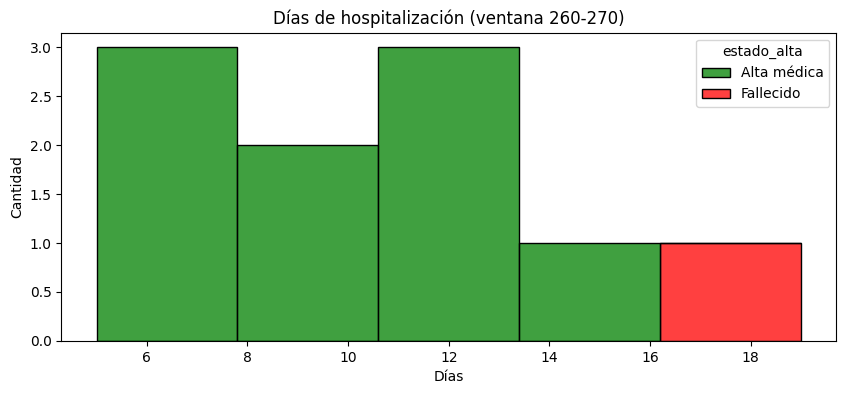

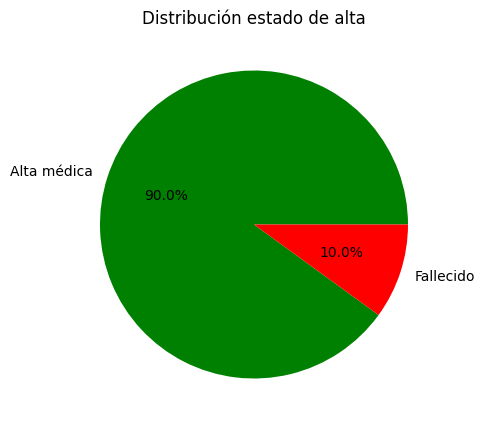


📦 Ventana 270-280 - Top críticos:


,paciente_id,nombre,apellido,edad,servicio_clinico,diagnostico_principal,dias_hospitalizacion,costo_total,estado_alta
271,272,Mario,Benítez,67,Neurología,Degeneración corticobasal,17,4500000,Fallecido
275,276,Eduardo,Cortez,66,Medicina Interna,Síndrome de Goodpasture,13,3200000,Fallecido
279,280,Pablo,Valenzuela,58,Neurología,Atrofia multisistémica,15,3800000,Fallecido
274,275,Carmen,Fuentes,41,Oncología,Tumor carcinoide,16,4800000,Alta médica


⚠️ Alertas de la ventana:
- Paciente 272 (Mario Benítez): Fallecido | Días: 17 | Costo: $4500000
- Paciente 276 (Eduardo Cortez): Fallecido | Días: 13 | Costo: $3200000
- Paciente 280 (Pablo Valenzuela): Fallecido | Días: 15 | Costo: $3800000
- Paciente 275 (Carmen Fuentes): Alta médica | Días: 16 | Costo: $4800000


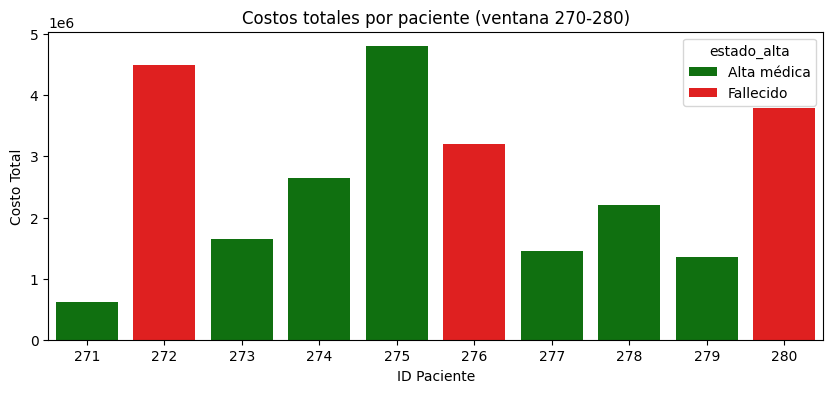

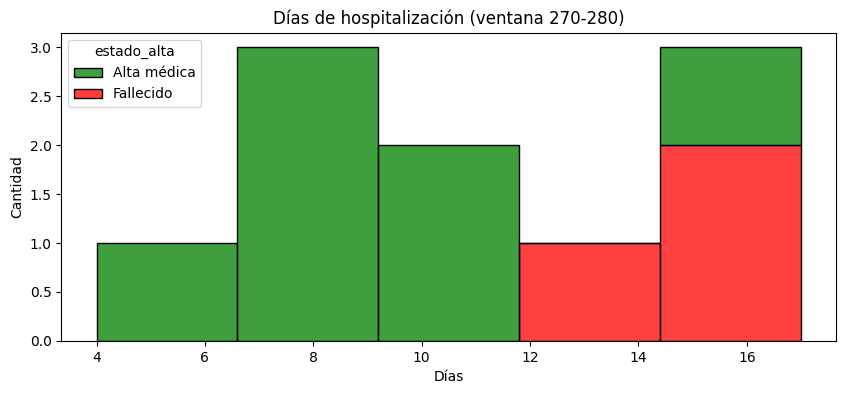

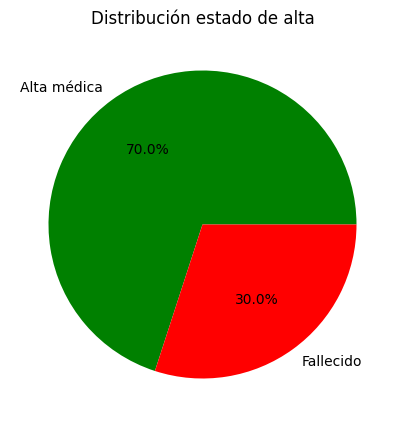

In [112]:
# Ventanas de 10 pacientes y 1 segundo de delay
ejecutar_flujo_dashboard(df, chunk_size=10, delay=1)

